# Supervised Learning: model training and evaluation

## *Bogdan Bošković*


# Learning Objectives:
This assignment will provide structured practice to help enable you to...
1. Understand the primary workflow in machine learning: (1) identifying a hypothesis function set of models, (2) determining a loss/cost/error/objective function to minimize, and (3) minimizing that function through gradient descent
2. Understand the inner workings of logistic regression and how linear models for classification can be developed.
3. Gain practice in implementing machine learning algorithms from the most basic building blocks to understand the math and programming behind them to achieve practical proficiency with the techniques
4. Implement batch gradient descent and become familiar with how that technique is used and its dependence on the choice of learning rate
5. Evaluate supervised learning algorithm performance through ROC curves and using cross validation
6. Apply regularization to linear models to improve model generalization performance

# 1
## Classification using logistic regression: build it from the ground up
**[60 points]**

This exercise will walk you through the full life-cycle of a supervised machine learning classification problem. Classification problem consists of two features/predictors (e.g. petal width and petal length) and your goal is to predict one of two possible classes (class 0 or class 1). You will build, train, and evaluate the performance of a logistic regression classifier on the data provided. Before you begin any modeling, you'll load and explore your data in Part I to familiarize yourself with it - and check for any missing or erroneous data. Then, in Part II, we will review an appropriate hypothesis set of functions to fit to the data: in this case, logistic regression. In Part III, we will derive an appropriate cost function for the data (spoiler alert: it's cross-entropy) as well as the gradient descent update equation that will allow you to optimize that cost function to identify the parameters that minimize the cost for the training data. In Part IV, all the pieces come together and you will implement your logistic regression model class including methods for fitting the data using gradient descent. Using that model you'll test it out and plot learning curves to verify the model learns as you train it and to identify and appropriate learning rate hyperparameter. Lastly, in Part V you will apply the model you designed, implemented, and verified to your actual data and evaluate and visualize its generalization performance as compared to a KNN algorithm. **When complete, you will have accomplished learning objectives 1-5 above!**

### I. Load, prepare, and plot your data
You are given some data for which you are tasked with constructing a classifier. The first step when facing any machine learning project: look at your data!

**(a)** Load the data.
- In the data folder in the same directory of this notebook, you'll find the data in `A3_Q1_data.csv`. This file contains the binary class labels, $y$, and the features $x_1$ and $x_2$.
- Divide your data into a training and testing set where the test set accounts for 30 percent of the data and the training set the remaining 70 percent.  
- Plot the training data by class.
- Comment on the data: do the data appear separable? May logistic regression be a good choice for these data? Why or why not?

**(b)** Do the data require any preprocessing due to missing values, scale differences (e.g. different ranges of values), etc.? If so, how did you handle these issues?

Next, we walk through our key steps for model fitting: choose a hypothesis set of models to train (in this case, logistic regression); identify a cost function to measure the model fit to our training data; optimize model parameters to minimize cost (in this case using gradient descent). Once we've completed model fitting, we will evaluate the performance of our model and compare performance to another approach (a KNN classifier).

---

**I.a. Loading, analyzing, and plotting the data:**

Train data shape: (140, 3)
Test data shape: (60, 3)
All training data are the same shape:        True
Are there any missing values: False


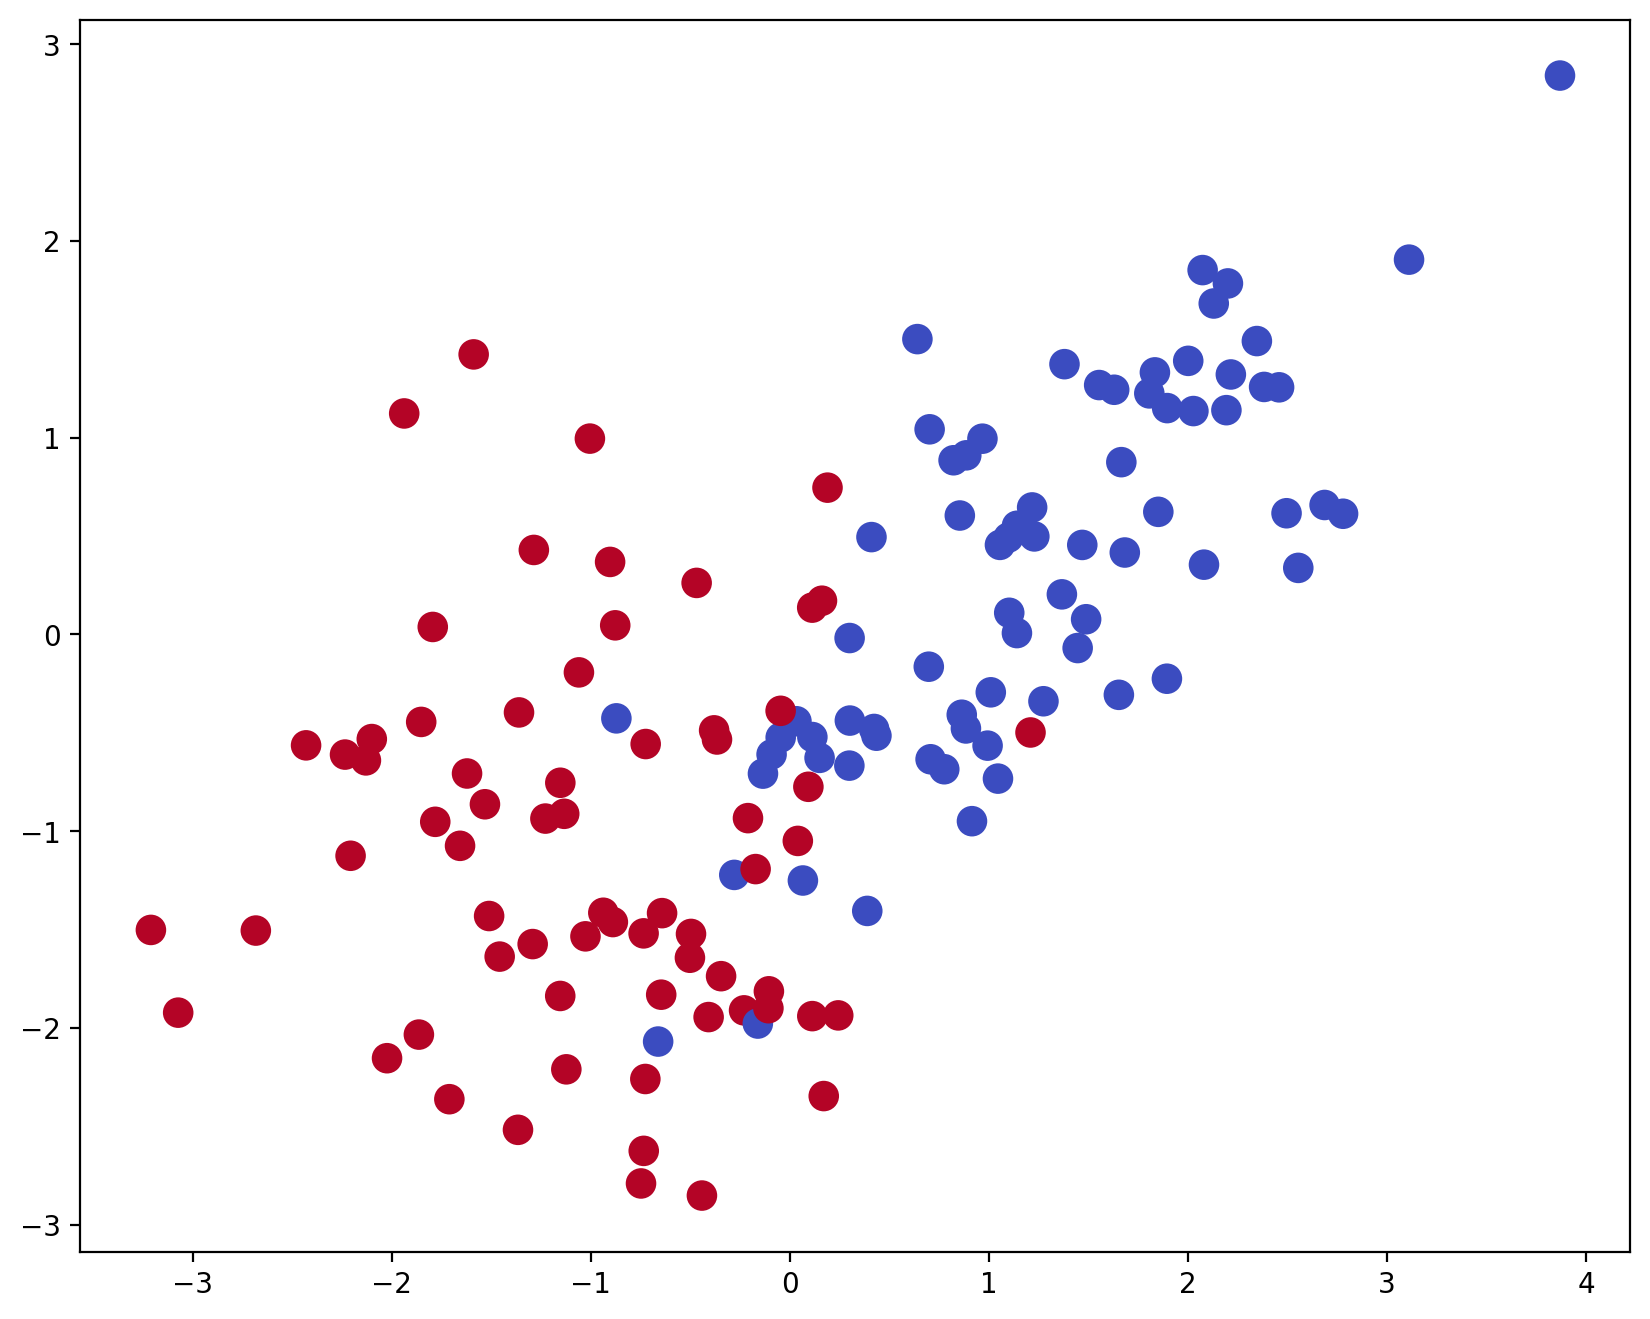

In [1]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np

# load the data
df = pd.read_csv('A3_Q1_data.csv')
X = np.column_stack((df.x1.values, df.x2.values))
y = df.y.values

# split the data into random training and testing sets
train = df.sample(frac=0.7)
test = df.drop(train.index)
print(f"Train data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

X_train = train.x1.values
x_train = train.x2.values
y_train = train.y.values
# check if all data are the same shape
print(f"All training data are the same shape: \
       {X_train.shape == x_train.shape == y_train.shape}")
# check if there are missing values
print(f"Are there any missing values: {train.isnull().values.any()}")

X_test = test.x1.values
x_test = test.x2.values
y_test = test.y.values

plt.figure(figsize=(10, 8), dpi=200)
plt.scatter(X_train, x_train, c=y_train, s=100, cmap='coolwarm')
plt.show()

**Comments:**

There is considerable overlap between the classes. However, it does seem like the data is a good candidate for logistic regression as the classes are visually separable into sections when plotted, for the most part.

**I.b. Preprocessing:**  

The console output above indicates that there are no missing values in the data. The data are also already scaled, so no additional preprocessing is required.

---

### II. Stating the hypothesis set of models to evaluate (we'll use logistic regression)

Given that our data consists of two features, our logistic regression problem will be applied to a two-dimensional feature space. Recall that our logistic regression model is:

$$f(\mathbf{x}_i,\mathbf{w})=\sigma(\mathbf{w}^{\top} \mathbf{x}_i)$$

where the sigmoid function is defined as $\sigma(x) = \dfrac{e^x}{1+e^{x}}= \dfrac{1}{1+e^{-x}}$. Also, since this is a two-dimensional problem, we define $\mathbf{w}^{\top} \mathbf{x}_i = w_0 x_{i,0} + w_1 x_{i,1} + w_2 x_{i,2}$ and here, $\mathbf{x}_i=[x_{i,0}, x_{i,1}, x_{i,2}]^{\top}$, and $x_{i,0} \triangleq 1$

Remember from class that we interpret our logistic regression classifier output (or confidence score) as the conditional probability that the target variable for a given sample $y_i$ is from class "1", given the observed features, $\mathbf{x}_i$. For one sample, $(y_i, \mathbf{x}_i)$, this is given as:

$$P(Y=1|X=\mathbf{x}_i) = f(\mathbf{x}_i,\mathbf{w})=\sigma(\mathbf{w}^{\top} \mathbf{x}_i)$$

In the context of maximizing the likelihood of our parameters given the data, we define this to be the likelihood function $L(\mathbf{w}|y_i,\mathbf{x}_i)$, corresponding to one sample observation from the training dataset.

*Aside: the careful reader will recognize this expression looks different from when we talk about the likelihood of our data given the true class label, typically expressed as $P(x|y)$, or the posterior probability of a class label given our data, typically expressed as $P(y|x)$. In the context of training a logistic regression model, the likelihood we are interested in is the likelihood function of our logistic regression **parameters**, $\mathbf{w}$. It's our goal to use this to choose the parameters to maximize the likelihood function.*

**No output is required for this section - just read and use this information in the later sections.**

### III. Find the cost function that we can use to choose the model parameters, $\mathbf{w}$, that best fit the training data.

**(c)** What is the likelihood function that corresponds to all the $N$ samples in our training dataset that we will wish to maximize? Unlike the likelihood function written above which gives the likelihood function for a *single training data pair* $(y_i, \mathbf{x}_i)$, this question asks for the likelihood function for the *entire training dataset* $\{(y_1, \mathbf{x}_1), (y_2, \mathbf{x}_2), ..., (y_N, \mathbf{x}_N)\}$.

**(d)** Since a logarithm is a monotonic function, maximizing the $f(x)$ is equivalent to maximizing $\ln [f(x)]$. Express the likelihood from the last question as a cost function of the model parameters, $C(\mathbf{w})$; that is the negative of the logarithm of the likelihood. Express this cost as an average cost per sample (i.e. divide your final value by $N$), and use this quantity going forward as the cost function to optimize.

**(e)** Calculate the gradient of the cost function with respect to the model parameters $\nabla_{\mathbf{w}}C(\mathbf{w})$. Express this in terms of the partial derivatives of the cost function with respect to each of the parameters, e.g. $\nabla_{\mathbf{w}}C(\mathbf{w}) = \left[\dfrac{\partial C}{\partial w_0}, \dfrac{\partial C}{\partial w_1}, \dfrac{\partial C}{\partial w_2}\right]$.

To simplify notation, please use $\mathbf{w}^{\top}\mathbf{x}$ instead of writing out $w_0 x_{i,0} + w_1 x_{i,1} + w_2 x_{i,2}$ when it appears each time (where $x_{i,0} = 1$ for all $i$). You are also welcome to use $\sigma()$ to represent the sigmoid function. Lastly, this will be a function the features, $x_{i,j}$ (with the first index in the subscript representing the observation and the second the feature; targets, $y_i$; and the logistic regression model parameters, $w_j$.

**(f)** Write out the gradient descent update equation. This should clearly express how to update each weight from one step in gradient descent $w_j^{(k)}$ to the next $w_j^{(k+1)}$.  There should be one equation for each model logistic regression model parameter (or you can represent it in vectorized form). Assume that $\eta$ represents the learning rate.

**c. Likelihood function for the entire training dataset:**
$$L(\mathbf{w}|y_i,\mathbf{x}_i) = \prod_{i=1}^{N} P(y_i=1|\mathbf{x}_i)^{y_i}P(y_i =0|\mathbf{x}_i)^{1-y_i} = \prod_{i=1}^{N} \sigma(\mathbf{w}^{\top} \mathbf{x}_i)^{y_i} (1-\sigma(\mathbf{w}^{\top} \mathbf{x}_i))^{1-y_i}$$

**d. Cost function:**
$$C(\mathbf{w}) = -\frac{1}{N} \ln L(\mathbf{w}|y_i,\mathbf{x}_i)
  = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \ln \sigma(\mathbf{w}^{\top} \mathbf{x}_i) + (1-y_i) \ln (1-\sigma(\mathbf{w}^{\top} \mathbf{x}_i)) \right]$$


**e. Gradient of the cost function:**

$$\nabla_{\mathbf{w}}C(\mathbf{w}) = \left[\dfrac{\partial C}{\partial w_0}, \dfrac{\partial C}{\partial w_1}, \dfrac{\partial C}{\partial w_2}\right]$$

$$\dfrac{\partial C}{\partial w_j} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \dfrac{\partial}{\partial w_j} \ln \sigma(\mathbf{w}^{\top} \mathbf{x}_i) + (1-y_i) \dfrac{\partial}{\partial w_j} \ln (1-\sigma(\mathbf{w}^{\top} \mathbf{x}_i)) \right]$$

$$ = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \dfrac{1}{\sigma(\mathbf{w}^{\top} \mathbf{x}_i)} \dfrac{\partial}{\partial w_j} \sigma(\mathbf{w}^{\top} \mathbf{x}_i) + (1-y_i) \dfrac{1}{1-\sigma(\mathbf{w}^{\top} \mathbf{x}_i)} \dfrac{\partial}{\partial w_j} (1-\sigma(\mathbf{w}^{\top} \mathbf{x}_i)) \right]$$

$$ = -\frac{1}{N} \sum_{i=1}^{N} \biggr[ y_i \dfrac{1}{\sigma(\mathbf{w}^{\top} \mathbf{x}_i)} \sigma(\mathbf{w}^{\top} \mathbf{x}_i) (1-\sigma(\mathbf{w}^{\top} \mathbf{x}_i)) \dfrac{\partial}{\partial w_j} \mathbf{w}^{\top} \mathbf{x}_i +
\\
(1-y_i) \dfrac{1}{1-\sigma(\mathbf{w}^{\top} \mathbf{x}_i)} \sigma(\mathbf{w}^{\top} \mathbf{x}_i) (1-\sigma(\mathbf{w}^{\top} \mathbf{x}_i)) \dfrac{\partial}{\partial w_j} \mathbf{w}^{\top} \mathbf{x}_i \biggr]$$

$$ = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i (1-\sigma(\mathbf{w}^{\top} \mathbf{x}_i)) x_{i,j} - (1-y_i) \sigma(\mathbf{w}^{\top} \mathbf{x}_i) x_{i,j} \right]$$

$$ = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i x_{i,j} - y_i \sigma(\mathbf{w}^{\top} \mathbf{x}_i) x_{i,j} - \sigma(\mathbf{w}^{\top} \mathbf{x}_i) x_{i,j} + y_i \sigma(\mathbf{w}^{\top} \mathbf{x}_i) x_{i,j} \right]$$

$$ = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i x_{i,j} - \sigma(\mathbf{w}^{\top} \mathbf{x}_i) x_{i,j} \right]$$

$$\dfrac{\partial C}{\partial w_j} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i - \sigma(\mathbf{w}^{\top} \mathbf{x}_i) \right] x_{i,j}$$

**f. Gradient descent update equation:**

$$w_j^{(k+1)} = w_j^{(k)} - \eta \dfrac{\partial C}{\partial w_j}$$

$$w_j^{(k+1)} = w_j^{(k)} + \eta \frac{1}{N} \sum_{i=1}^{N} \left[ y_i - \sigma(\mathbf{w}^{\top} \mathbf{x}_i) \right] x_{i,j}$$

---

### IV. Implement gradient descent and your logistic regression algorithm

**(g)** Implement your logistic regression model.

- You are provided with a template, below, for a class with key methods to help with your model development. It is modeled on the Scikit-Learn convention. For this, you only need to create a version of logistic regression for the case of two feature variables (i.e. two predictors).
- Create a method called `sigmoid` that calculates the sigmoid function
- Create a method called `cost` that computes the cost function $C(\mathbf{w})$ for a given dataset and corresponding class labels. This should be the **average cost** (make sure your total cost is divided by your number of samples in the dataset).
- Create a method called `gradient_descent` to run **one step** of gradient descent on your training data. We'll refer to this as "batch" gradient descent since it takes into account the gradient based on all our data at each iteration of the algorithm.
- Create a method called `fit` that fits the model to the data (i.e. sets the model parameters to minimize cost) using your `gradient_descent` method. In doing this we'll need to make some assumptions about the following:
  
    - Weight initialization. What should you initialize the model parameters to? For this, randomly initialize the weights to a different values between 0 and 1.
    - Learning rate. How slow/fast should the algorithm step towards the minimum? This you will vary in a later part of this problem.
    - Stopping criteria. When should the algorithm be finished searching for the optimum? There are two stopping criteria: small changes in the gradient descent step size and a maximum number of iterations. The first is whether there was a sufficiently small change in the gradient; this is evaluated as whether the magnitude of the step that the gradient descent algorithm takes changes by less than $10^{-6}$ between iterations. Since we have a weight vector, we can compute the change in the weight by evaluating the $L_2$ norm (Euclidean norm) of the change in the vector between iterations. From our gradient descent update equation we know that mathematically this is $||-\eta\nabla_{\mathbf{w}}C(\mathbf{w})||$. The second criterion is met if a maximum number of iterations has been reach (5,000 in this case, to prevent infinite loops from poor choices of learning rates).
    - Design your approach so that at each step in the gradient descent algorithm you evaluate the cost function for both the training and the test data for each new value for the model weights. You should be able to plot cost vs gradient descent iteration for both the training and the test data. This will allow you to plot "learning curves" that can be informative for how the model training process is proceeding.
  
- Create a method called `predict_proba` that predicts confidence scores (that can be thresholded into the predictions of the `predict` method.
- Create a method called `predict` that makes predictions based on the trained model, selecting the most probable class, given the data, as the prediction, that is class that yields the larger $P(y|\mathbf{x})$.
- (Optional, but recommended) Create a method called `learning_curve` that produces the cost function values that correspond to each step from a previously run gradient descent operation.
- (Optional, but recommended) Create a method called `prepare_x` which appends a column of ones as the first feature of the dataset $\mathbf{X}$ to account for the bias term ($x_{i,1}=1$).

This structure is strongly encouraged; however, you're welcome to adjust this to your needs (adding helper methods, modifying parameters, etc.).

In [2]:
import numpy as np
# Logistic regression class
class Logistic_regression:
    # Class constructor
    def __init__(self):
        self.w = None       # logistic regression weights
        self.saved_w = []   # Since this is a small problem, we can save the weights
                            # at each iteration of gradient descent to build our
                            # learning curves

    # Method calculating the sigmoid function of w^T X for an input set of weights
    def sigmoid(self, X, w):
        # transpose w
        w = w.T
        # transpose X
        # NOT YET SURE WHY THIS IS NECESSARY, BUT THE SHAPES AREN'T RIGHT OTHERWISE
        X = X.T
        # calculate w^T X
        wTx = np.dot(w, X)
        # calculate sigmoid
        sigmoid = 1 / (1 + np.exp(-wTx))
        return sigmoid

    # Cost function for an input set of weights
    def cost(self, X, y, w):
        sigmoid = self.sigmoid(X, w)
        # calculate cost
        cost = np.mean(y * np.log(sigmoid) - (1 - y) * np.log(1 - sigmoid))
        return cost

    # Update the weights in an iteration of gradient descent
    def gradient_descent(self, X, y, lr):
        # returns a scalar of the magnitude of the Euclidean norm
        # of the change in the weights during one gradient descent step
        # reshape y-self.sigmoid(X, self.w) to (x,1)
        diff = (y-self.sigmoid(X, self.w)).reshape(-1, 1)
        # perform element-wise multiplication
        cost_gradient = -np.mean(diff*X, axis=0)
        # save current weight
        previous = self.w
        # update weight
        self.w = self.w - lr*cost_gradient
        # save weights
        self.saved_w.append(self.w)
        # return the magnitude of the change in weights
        return np.linalg.norm(self.w-previous)

    # Fit the logistic regression model to the data through gradient descent
    def fit(self, X, y, w_init, lr, delta_thresh=1e-6, max_iter=5000, verbose=True):
        # Note the verbose flag enables you to print out the weights at each 
        # iteration (optional - but may help with one of the questions)
        self.w = w_init # initialize the weights
        self._is_fitted = True
        for i in range(max_iter):
            # get the change in weights from one iteration of gradient descent
            delta = self.gradient_descent(X, y, lr)
            # print out the weights at each iteration if verbose is True
            if verbose:
                if i < 4 or i > 45:
                    print(f"Iteration {i+1}: w = {self.w}")
                if i == 49:
                    print("Ending iteration at i = 50")
                    break
            if delta < delta_thresh:
                print(f"FITTING CONVERGED AT ITERATION {i+1} with LR = {lr}")
                break
            
    # Use the trained model to predict the confidence scores 
    # (prob of positive class in this case)
    def predict_proba(self, X):
        # returns the confidence score for each sample
        proba = self.sigmoid(X, self.w)
        return proba

    # Use the trained model to make binary predictions
    def predict(self, X, thresh=0.5):
        # returns a binary prediction for each sample
        proba = self.predict_proba(X)
        pred = np.where(proba > thresh, 1, 0)
        return pred

    # Stores the learning curves from saved weights from gradient descent
    def learning_curve(self, X, y):
        # returns the value of the cost function from each step in 
        # gradient descent from the last model fitting process
        costs = []
        for i in range(len(self.saved_w)):
            costs = np.append(costs, self.cost(X, y, self.saved_w[i]))
        return costs

    # Appends a column of ones as the first feature to account for the bias term
    def prepare_x(self, X):
        # returns the X with a new feature of all ones 
        # (a column that is the new column 0)
        X = np.insert(X, 0, 1, axis=1)
        return X
    
    def __sklearn_is_fitted__(self):
        return hasattr(self, "_is_fitted") and self._is_fitted

**(h)** Choose a learning rate and fit your model. Learning curves are a plot of metrics of model performance evaluated through the process of model training to provide insight about how model training is proceeding. Show the learning curves for the gradient descent process for learning rates of $\{10^{-0}, 10^{-2}, 10^{-4}\}$. For each learning rate plot the learning curves by plotting **both the training and test data average cost** as a function of each iteration of gradient descent. You should run the model fitting process until it completes (up to 5,000 iterations of gradient descent). Each of the 6 resulting curves (train and test average cost for each learning rate) should be plotted on the **same set of axes** to enable direct comparison. *Note: make sure you're using average cost per sample, not the total cost*.

- Try running this process for a really big learning rate for this problem: $10^1$. Look at the weights that the fitting process generates over the first 50 iterations and how they change. Either print these first 50 iterations as console output or plot them. What happens? How does the output compare to that corresponding to a learning rate of $10^0$ and why?
- What is the impact that the different values of learning have on the speed of the process and the results?
- Of the options explored, what learning rate do you prefer and why?
- Use your chosen learning rate for the remainder of this problem.

Initial weights: [0.6769549  0.32818702 0.95850297]
FITTING CONVERGED AT ITERATION 579 with LR = 1
Accuracy on training set with learning rate 1: 0.9
Accuracy on training set with learning rate 0.01: 0.9071428571428571
Accuracy on training set with learning rate 0.0001: 0.2785714285714286
FITTING CONVERGED AT ITERATION 253 with LR = 1
Accuracy on testing set with learning rate 1: 0.8166666666666667
Accuracy on testing set with learning rate 0.01: 0.8166666666666667
Accuracy on testing set with learning rate 0.0001: 0.23333333333333334


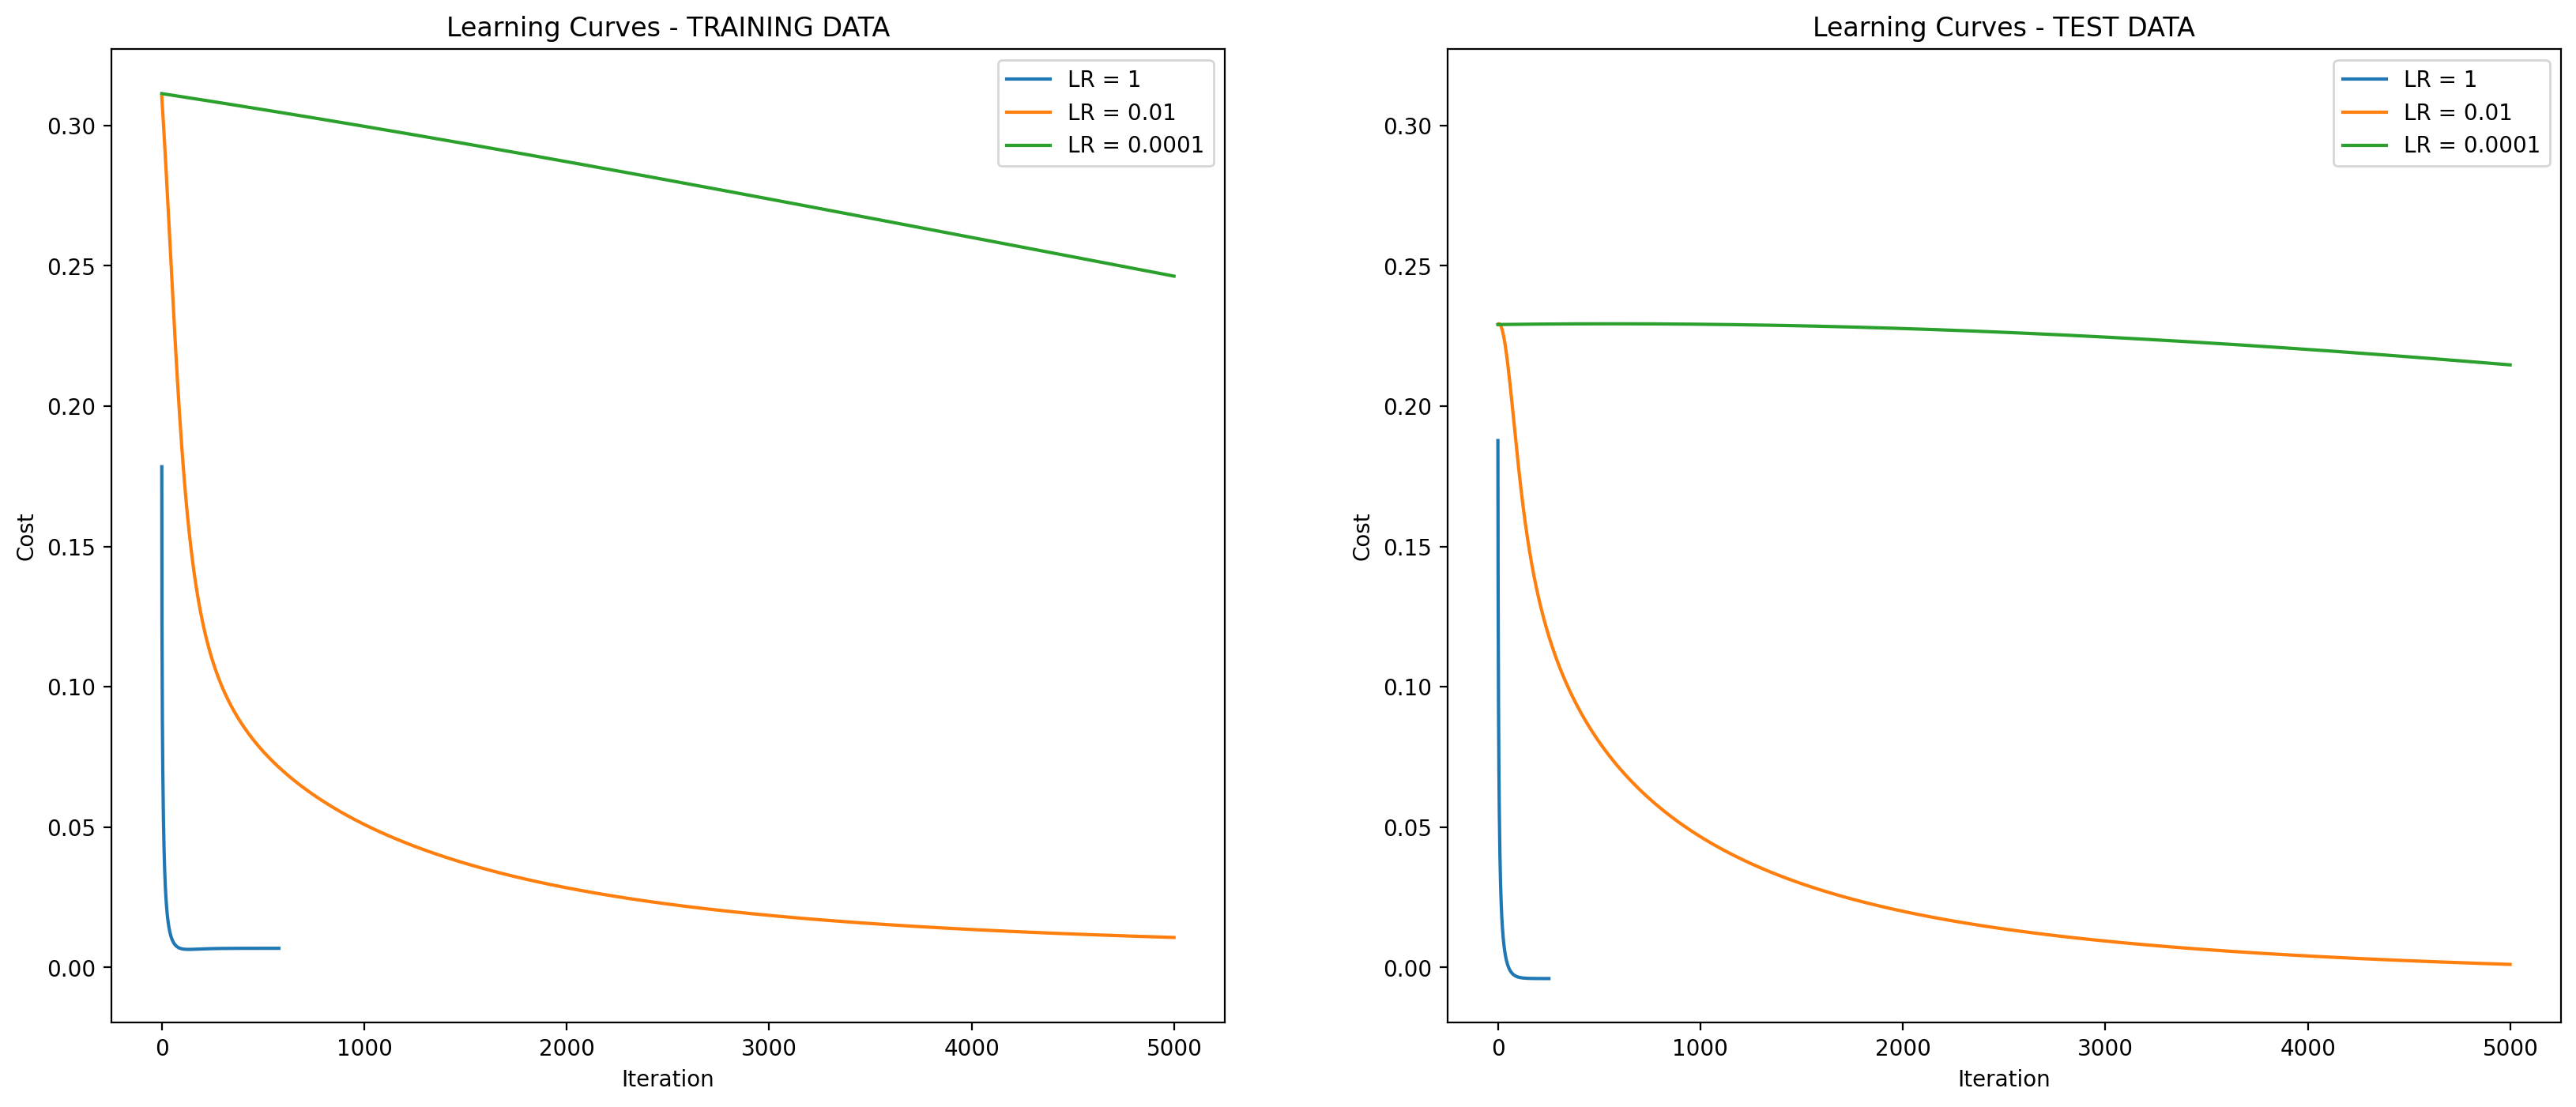

In [3]:
# initialize the learning rates
lrs = [1, 0.01, 0.0001]
# initialize the logistic regression model
loggy = Logistic_regression()

X_train_combined = np.column_stack((X_train, x_train))
# prepare the training data
X_train_prep = loggy.prepare_x(X_train_combined)

# initialize the weights-- random values between 0 and 1, with the same shape as X
w_init = np.random.uniform(0, 1, size=X_train_prep.shape[1])
print(f"Initial weights: {w_init}")

# train the model for each learning rate, on training set
train_curves = []
for lr in lrs:
    loggy.fit(X_train_prep, y_train, w_init, lr, verbose=False)
    # print acc for testing purposes
    accuracy = np.mean(loggy.predict(X_train_prep) == y_train)
    print(f"Accuracy on training set with learning rate {lr}: {accuracy}")
    train_curves.append(loggy.learning_curve(X_train_prep, y_train))
    loggy = Logistic_regression()

X_test_combined = np.column_stack((X_test, x_test))
# prepare the TESTING data
X_test_prep = loggy.prepare_x(X_test_combined)

# train the model for each learning rate, on testing set
test_curves = []
for lr in lrs:
    loggy.fit(X_test_prep, y_test, w_init, lr, verbose=False)
    # print acc for testing purposes
    accuracy = np.mean(loggy.predict(X_test_prep) == y_test)
    print(f"Accuracy on testing set with learning rate {lr}: {accuracy}")
    test_curves.append(loggy.learning_curve(X_test_prep, y_test))
    loggy = Logistic_regression()

# plot the learning curves
plt.figure(figsize=(20, 8), dpi=200)
plt.subplot(1, 2, 1)
for i in range(len(lrs)):
    plt.plot(train_curves[i], label=f"LR = {lrs[i]}")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Learning Curves - TRAINING DATA")
plt.legend()

plt.subplot(1, 2, 2, sharey=plt.gca())
for i in range(len(lrs)):
    plt.plot(test_curves[i], label=f"LR = {lrs[i]}")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Learning Curves - TEST DATA")
plt.legend()

plt.show()

**Plotting the learning curve for LR = $10^{1}$ :**

Iteration 1: w = [ 0.59647456 -0.54975787  0.33420986]
Iteration 2: w = [ 0.48857948 -0.95559232  0.06494546]
Iteration 3: w = [ 0.41004873 -1.16375353 -0.05422077]
Iteration 4: w = [ 0.34681574 -1.30921365 -0.1276225 ]
Iteration 47: w = [-0.22380246 -2.58721966 -0.47720139]
Iteration 48: w = [-0.22600524 -2.59671575 -0.47801343]
Iteration 49: w = [-0.22808501 -2.60593795 -0.47876169]
Iteration 50: w = [-0.23004832 -2.61489714 -0.47944964]
Ending iteration at i = 50
Accuracy on training set with learning rate 1: 0.9071428571428571
Iteration 1: w = [-0.12784844 -8.45126186 -5.28442813]
Iteration 2: w = [-0.79413181 -8.28206133 -4.3527917 ]
Iteration 3: w = [-1.30233848 -8.07973767 -3.50953202]
Iteration 4: w = [-1.63567227 -7.8554657  -2.78743106]
Iteration 47: w = [-0.22508511 -3.02718529 -0.44167341]
Iteration 48: w = [-0.22614186 -3.0242333  -0.44270706]
Iteration 49: w = [-0.22703905 -3.0217493  -0.44358347]
Iteration 50: w = [-0.22779968 -3.01965956 -0.44432561]
Ending iteration at

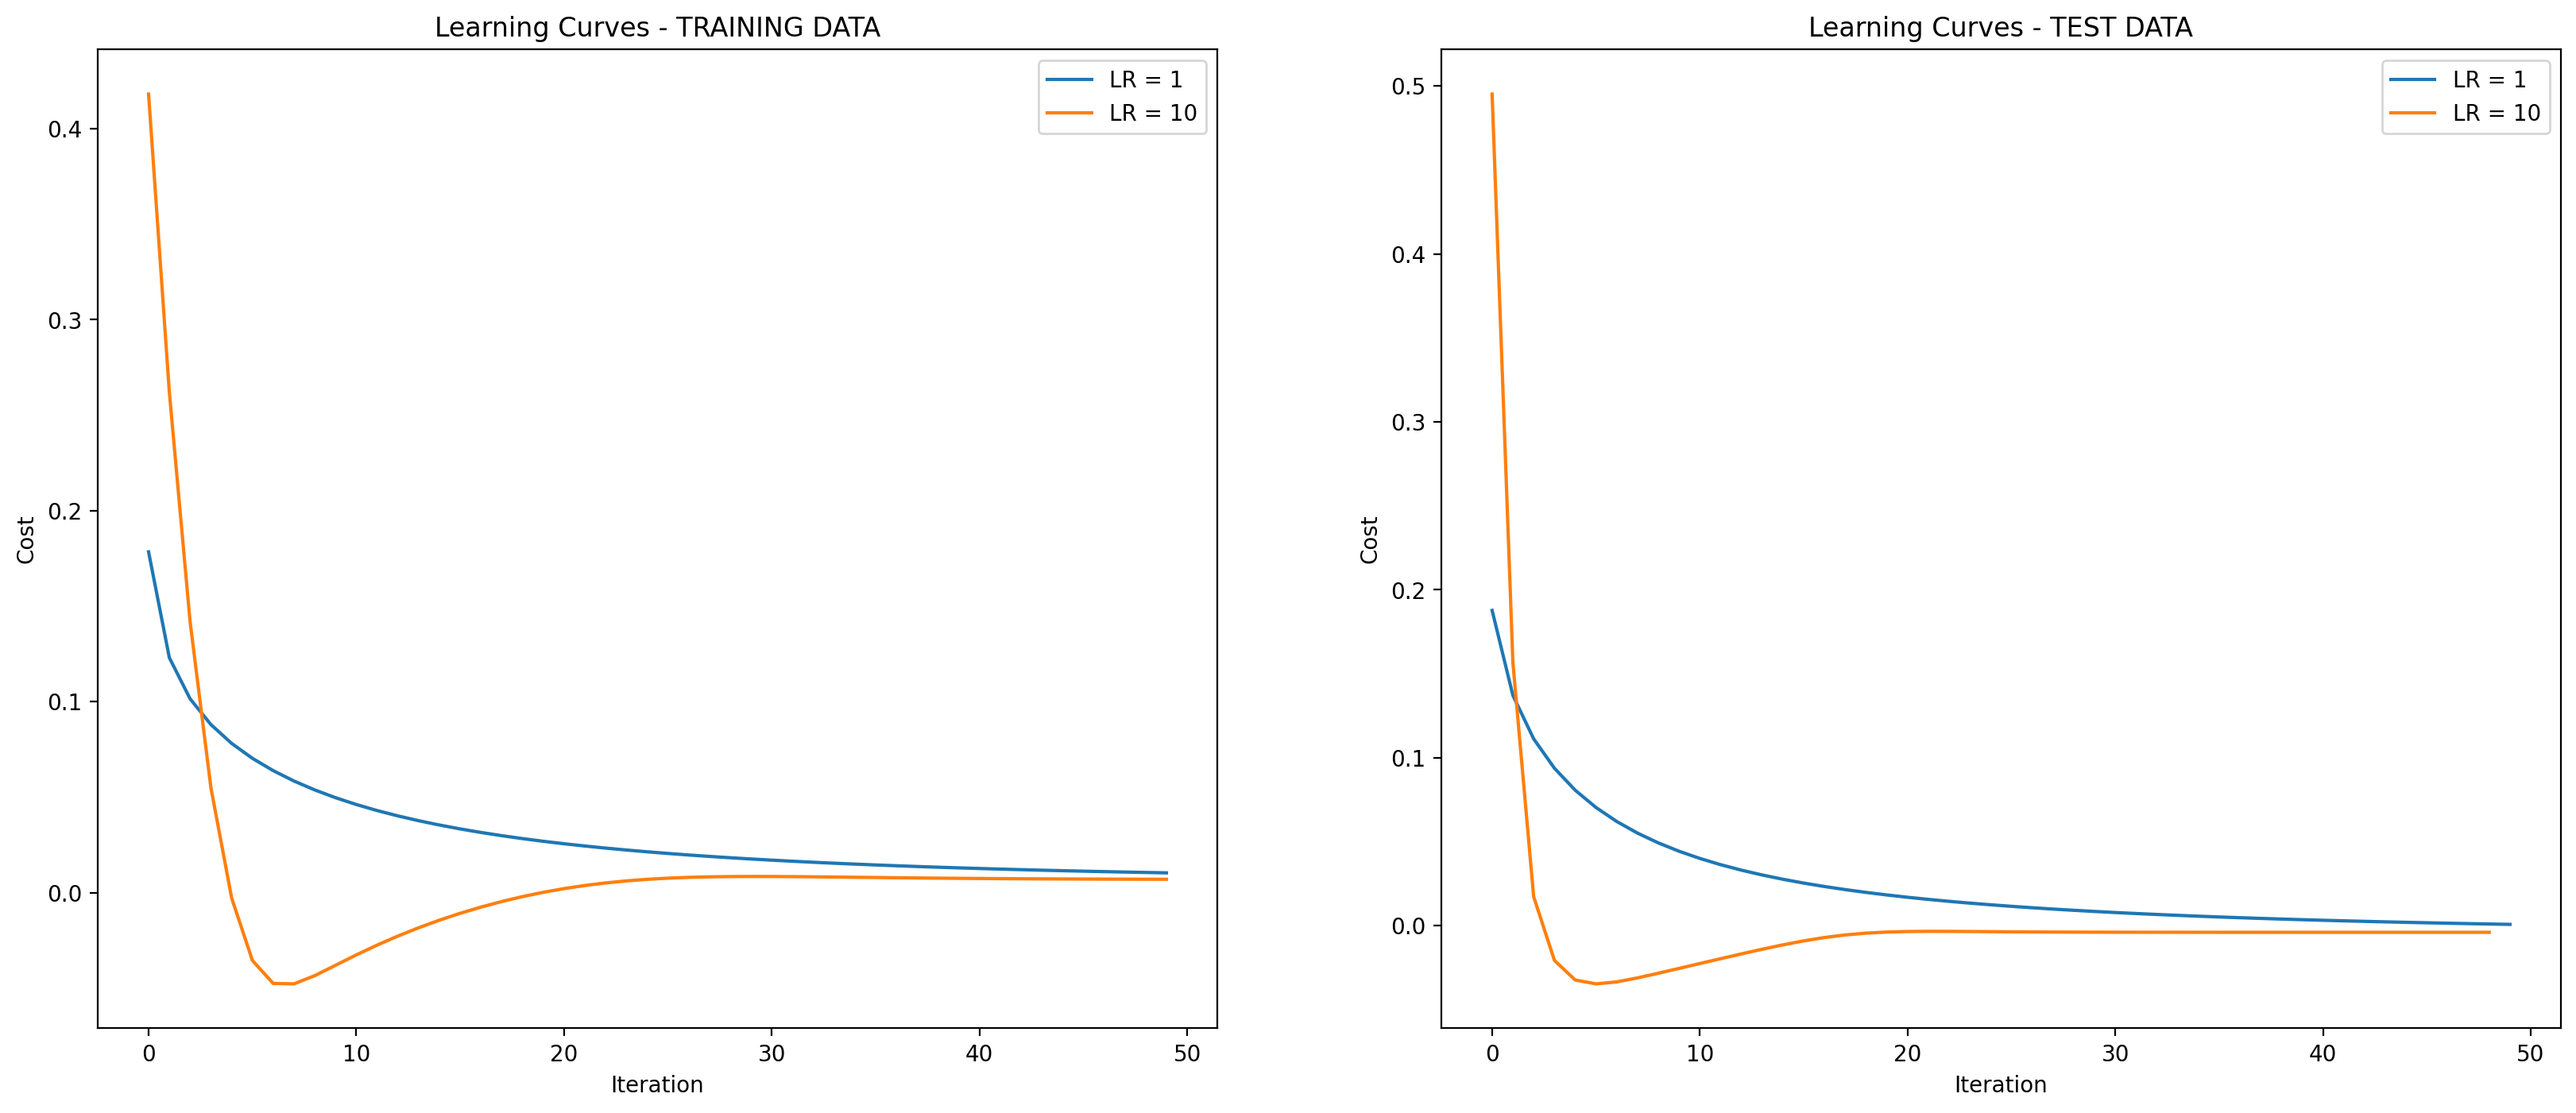

In [4]:
lrs = [1, 10]
# initialize the logistic regression model
loggy = Logistic_regression()

# train the model for each learning rate, on training set
train_curves = []
for lr in lrs:
    loggy.fit(X_train_prep, y_train, w_init, lr, verbose=True)
    # print acc for testing purposes
    accuracy = np.mean(loggy.predict(X_train_prep) == y_train)
    print(f"Accuracy on training set with learning rate {lr}: {accuracy}")
    train_curves.append(loggy.learning_curve(X_train_prep, y_train))
    loggy = Logistic_regression()

# train the model for each learning rate, on testing set
test_curves = []
for lr in lrs:
    loggy.fit(X_test_prep, y_test, w_init, lr, verbose=True)
    # print acc for testing purposes
    accuracy = np.mean(loggy.predict(X_test_prep) == y_test)
    print(f"Accuracy on testing set with learning rate {lr}: {accuracy}")
    test_curves.append(loggy.learning_curve(X_test_prep, y_test))
    loggy = Logistic_regression()

# plot the learning curves
plt.figure(figsize=(20, 8), dpi=200)
plt.subplot(1, 2, 1)
for i in range(len(lrs)):
    plt.plot(train_curves[i], label=f"LR = {lrs[i]}")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Learning Curves - TRAINING DATA")
plt.legend()

plt.subplot(1, 2, 2)
for i in range(len(lrs)):
    plt.plot(test_curves[i], label=f"LR = {lrs[i]}")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Learning Curves - TEST DATA")
plt.legend()

plt.show()

Costs take a large dip into the negative and have to correct themselves with a learning rate as high as $10$, unlike when the learning rate is set to $10^{-2}$ or even $10^0$. In both cases though, the cost stabilizes after about 10 iterations.

Low learning rates will take longer to converge, but will be more accurate. 5000 iterations is not nearly enough for a logistic regression model with a learning rate of $10^{-4}$ to converge. High learning rates will converge faster, but will be less accurate. I prefer the learning rate of $10^{-2}$ because it converges quickly and is likely to be more accurate than the learning rate of $10^{1}$.

### V. Evaluate your model performance through cross validation

**(i)** Test the performance of your trained classifier using K-folds cross validation resampling technique. The scikit-learn package [StratifiedKFolds](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) may be helpful.

- Train your logistic regression model and a K-Nearest Neighbor classification model with $k=7$ nearest neighbors.
- Using the trained models, make four plots: two for logistic regression and two for KNN. For each model have one plot showing the training data used for fitting the model, and the other showing the test data. On each plot, include the decision boundary resulting from your trained classifier.
- Produce a Receiver Operating Characteristic curve (ROC curve) that represents the performance from cross validated performance evaluation for each classifier (your logistic regression model and the KNN model, with $k=7$ nearest neighbors). For the cross validation, use $k=10$ folds.

  - Plot these curves on the same set of axes to compare them
  - On the ROC curve plot, also include the chance diagonal for reference (this represents the performance of the worst possible classifier). This is represented as a line from $(0,0)$ to $(1,1)$.
  - Calculate the Area Under the Curve for each model and include this measure in the legend of the ROC plot.


- Comment on the following:

  - What is the purpose of using cross validation for this problem?
  - How do the models compare in terms of performance (both ROC curves and decision boundaries) and which model (logistic regression or KNN) would you select to use on previously unseen data for this problem and why?

**ANSWER**

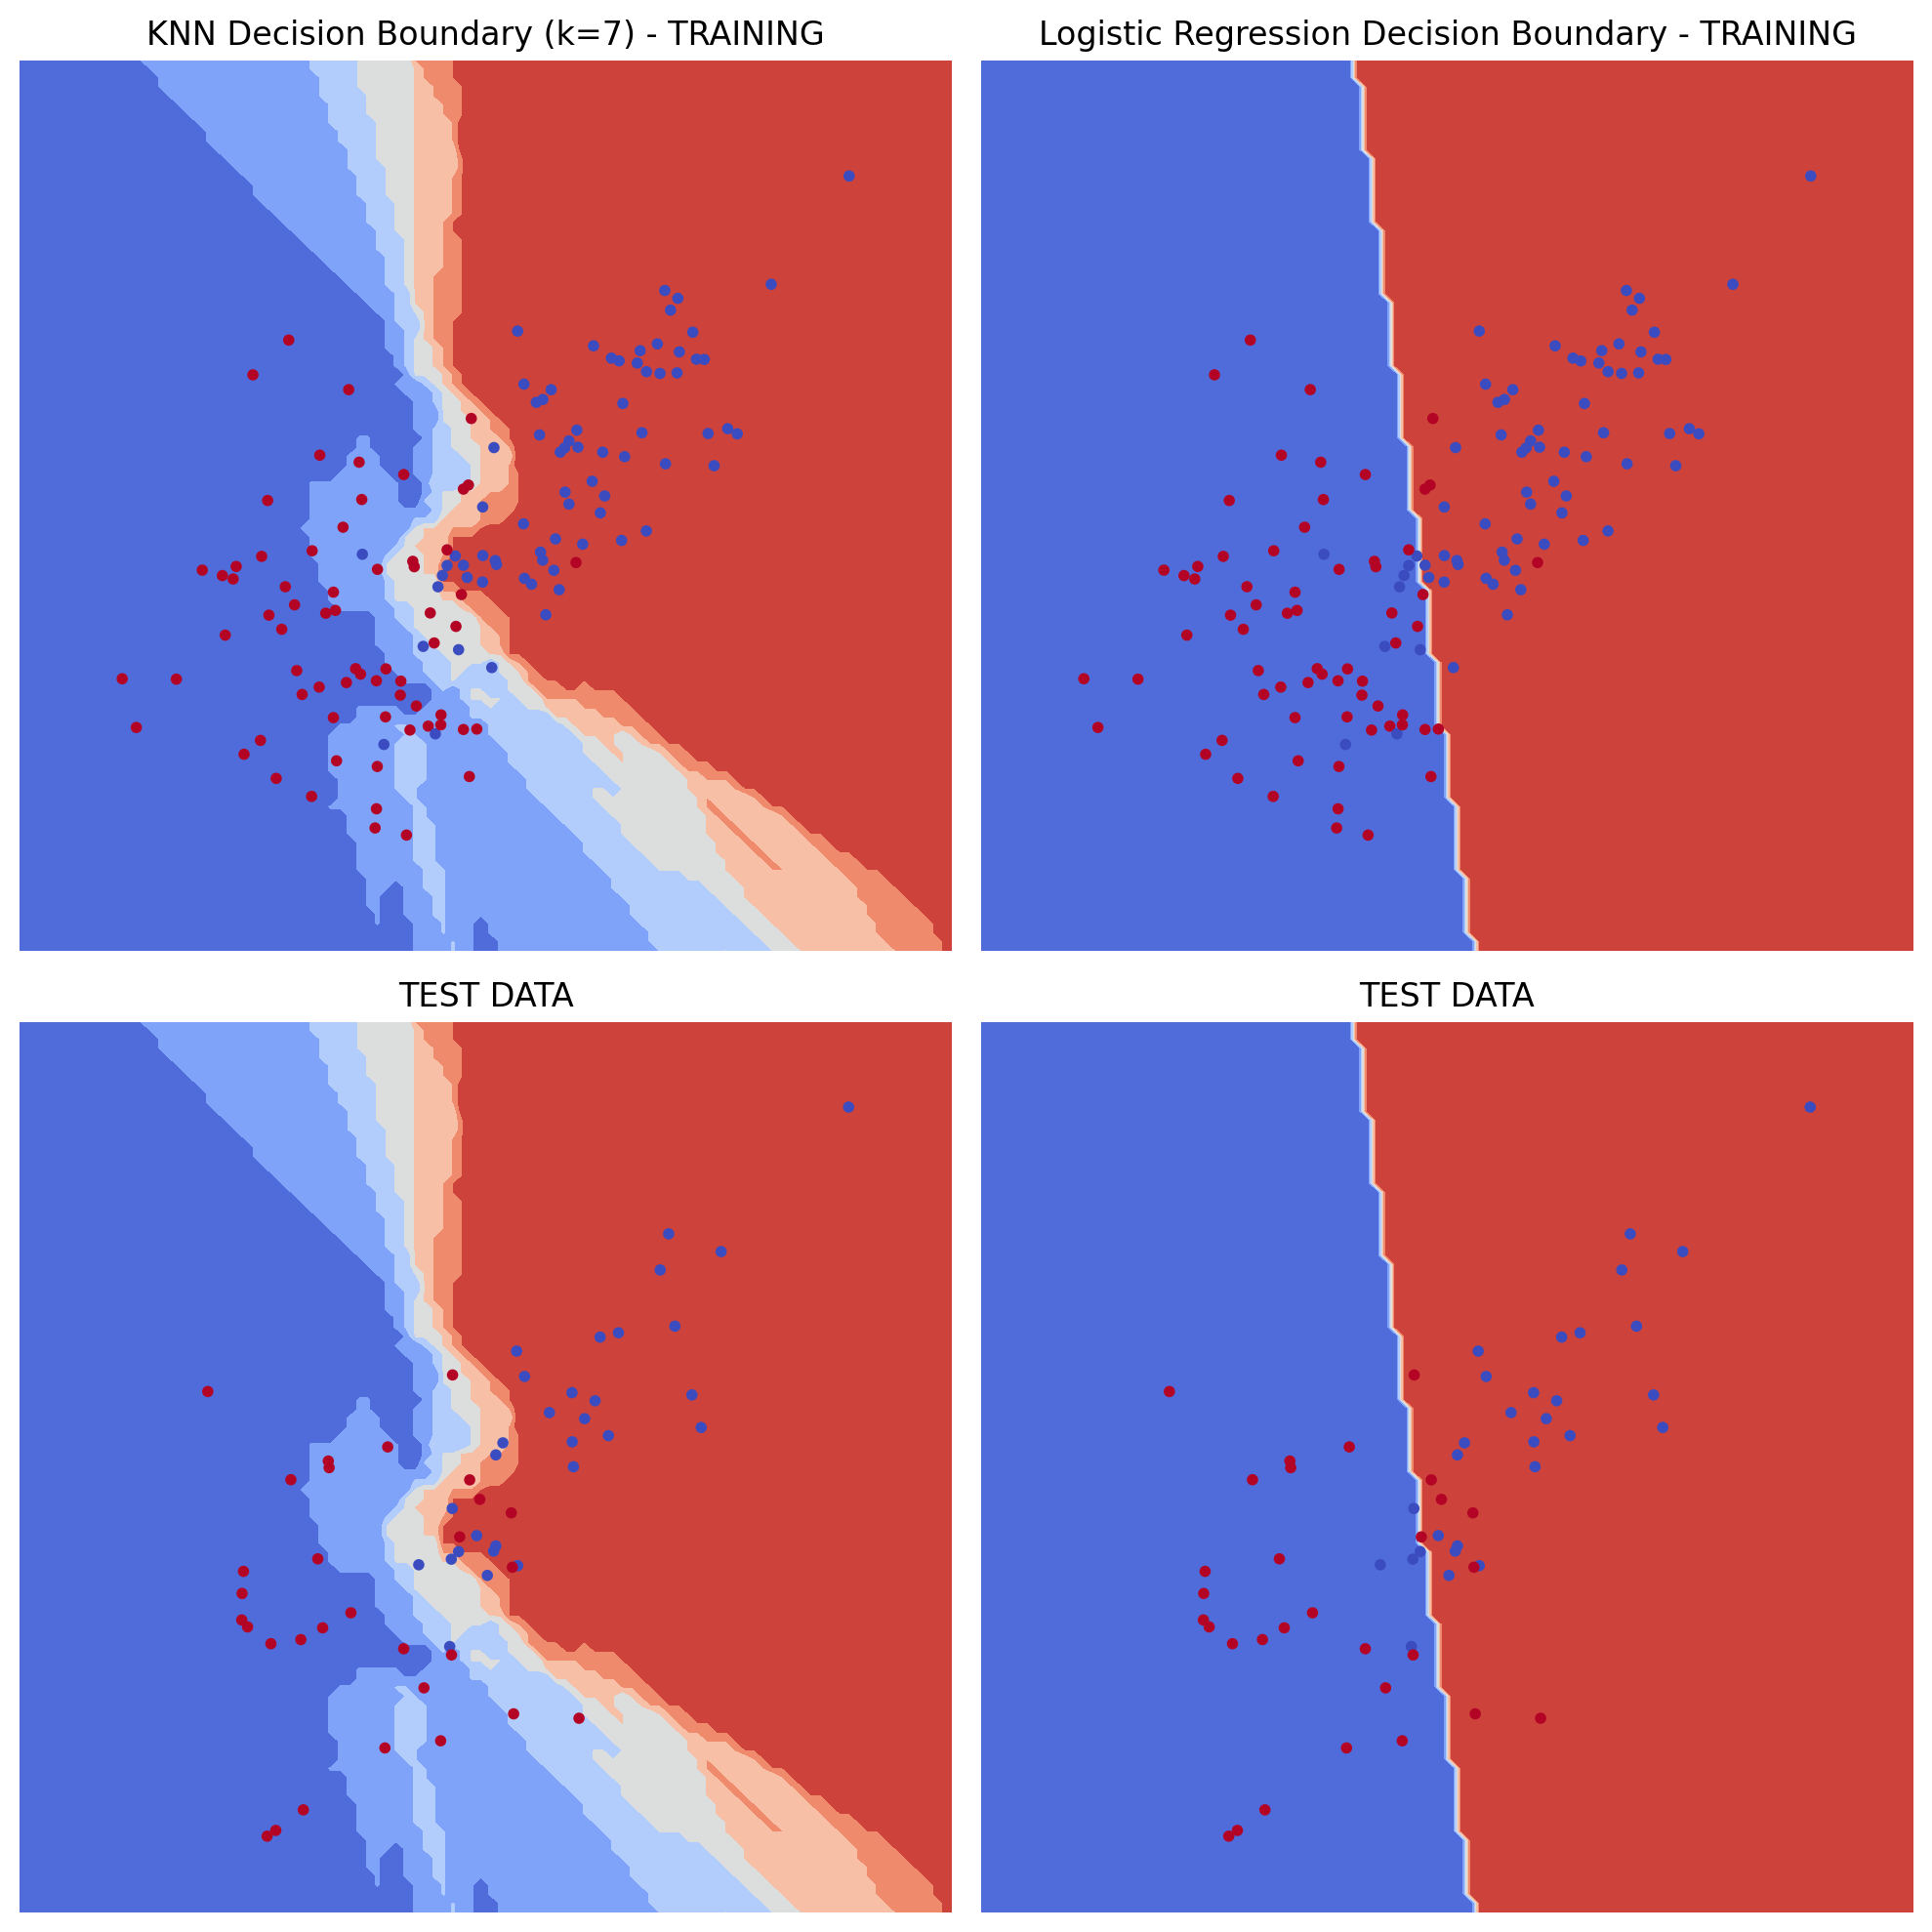

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay

logorrhea = Logistic_regression()
knob = KNeighborsClassifier(n_neighbors=7)
# prepare weights again, because decision boundary object can't take 3 features
w_init = np.random.uniform(0, 1, size=X_train_combined.shape[1])

# train my LR
logorrhea.fit(X_train_combined, y_train, w_init, 0.01, verbose=False)
# train the KNN
knob.fit(X_train_combined, y_train)

fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=200)

# initialize decisionboundarydisplay with my LR
display_knn = DecisionBoundaryDisplay.from_estimator(knob, X=X_train_combined, 
                                                     response_method="predict_proba")
display_knn.plot(ax=axs[0,0], cmap='coolwarm_r')
axs[0,0].scatter(X_train, x_train, c=y_train, s=10, cmap='coolwarm')
axs[0,0].set_title("KNN Decision Boundary (k=7) - TRAINING")
axs[0,0].axis('off')
plt.close()

display_lr = DecisionBoundaryDisplay.from_estimator(logorrhea, X=X_train_combined,
                                                     response_method="predict")
display_lr.plot(ax=axs[0,1], cmap='coolwarm_r')
axs[0,1].scatter(X_train, x_train, c=y_train, s=10, cmap='coolwarm')
axs[0,1].set_title("Logistic Regression Decision Boundary - TRAINING")
axs[0,1].axis('off')
plt.close()

display_knn.plot(ax=axs[1,0], cmap='coolwarm_r')
axs[1,0].scatter(X_test, x_test, c=y_test, s=10, cmap='coolwarm')
axs[1,0].set_title("TEST DATA")
axs[1,0].axis('off')

display_lr.plot(ax=axs[1,1], cmap='coolwarm_r')
axs[1,1].scatter(X_test, x_test, c=y_test, s=10, cmap='coolwarm')
axs[1,1].set_title("TEST DATA")
axs[1,1].axis('off')
# set tight layout
fig.tight_layout()
plt.show()

**Plotting ROC curves:**

Logistic Regression mean AUC: 0.95
KNN mean AUC: 0.94


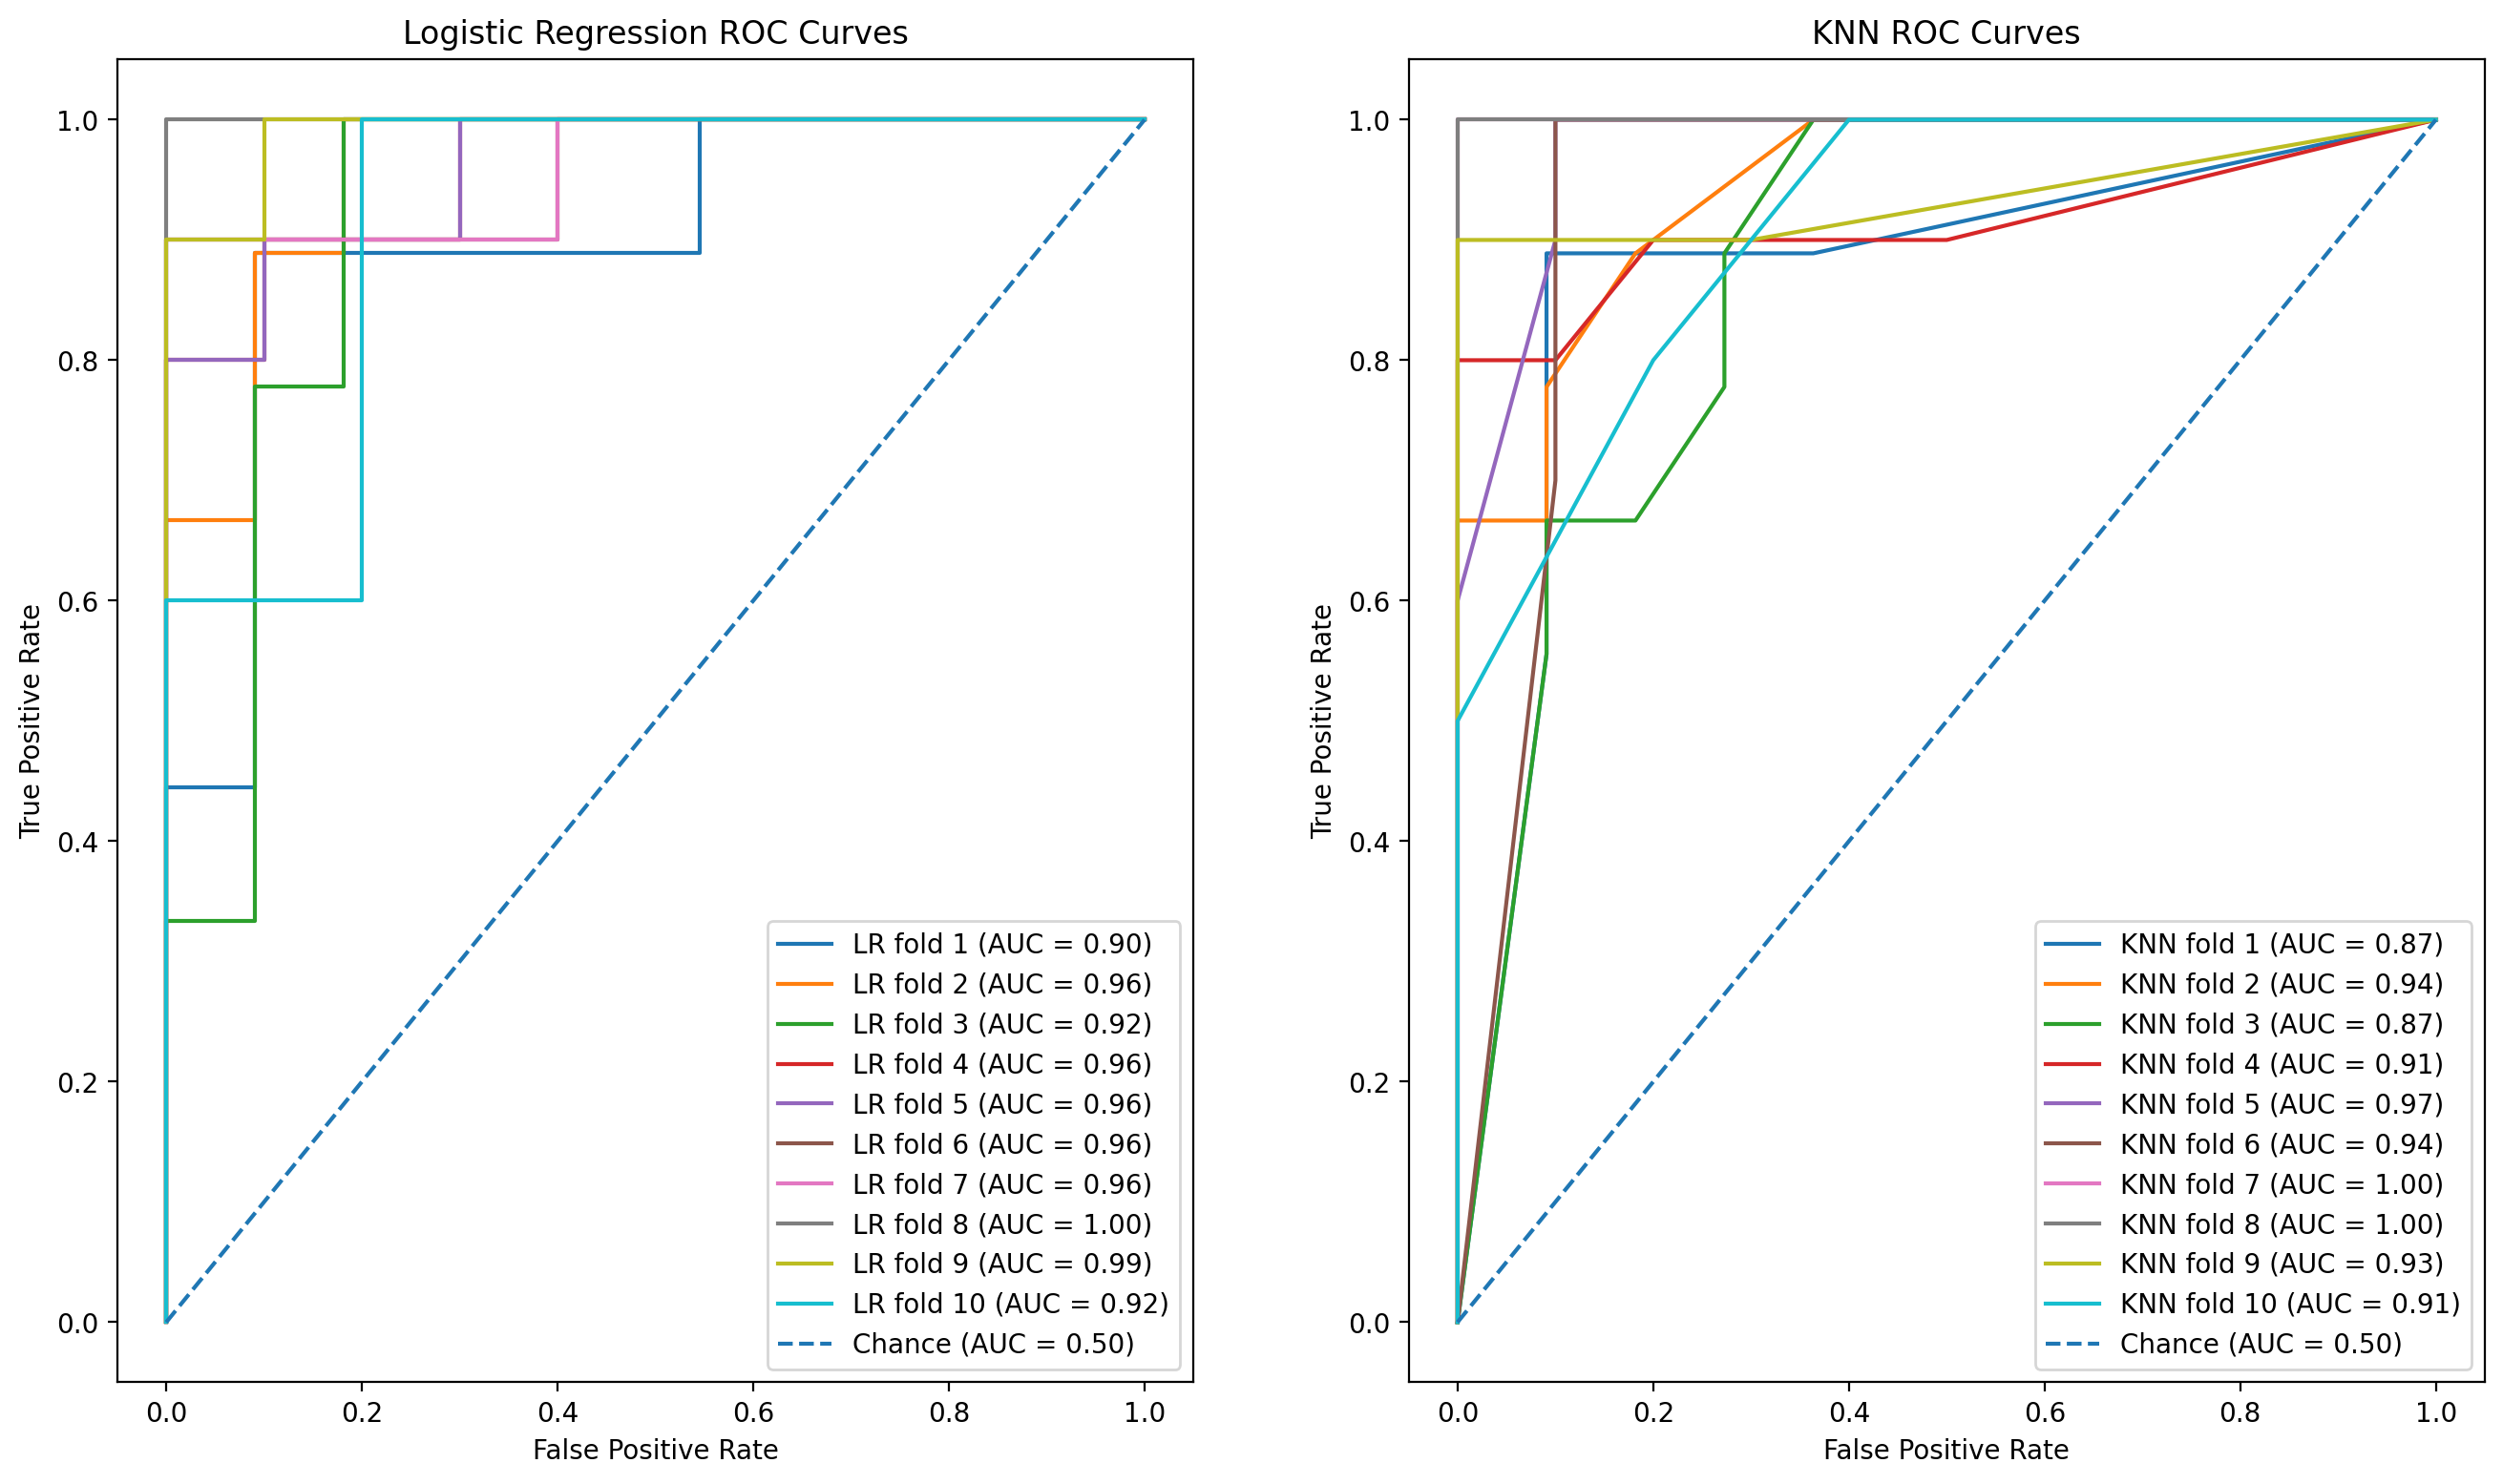

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve

# produce a ROC curve for both models showing cross validated performance
skf = StratifiedKFold(n_splits=10, shuffle=True)

# initialize the logistic regression model
logorrhea = Logistic_regression()
# initialize the KNN
knob = KNeighborsClassifier(n_neighbors=7)

knn_aucs = []
lr_aucs = []

fig, axs = plt.subplots(1, 2, figsize=(16, 9), dpi=200)
for fold, (train, test) in enumerate(skf.split(X, y)):
    # get the training and testing data
    X_train, y_train = X[train], y[train]
    X_test, y_test = X[test], y[test]
    # train my LR
    logorrhea.fit(X_train, y_train, w_init, 0.01, verbose=False)
    # train the KNN
    knob.fit(X_train, y_train)
    # get the probabilities for each class
    lr_probs = logorrhea.predict_proba(X_test)
    knn_probs = knob.predict_proba(X_test)
    # since knn.predict_proba() returns a 2D array, 
    # we need to get the probs for the positive class
    knn_probs = knn_probs[:, 1]
    # calculate scores
    lr_auc = roc_auc_score(y_test, lr_probs)
    knn_auc = roc_auc_score(y_test, knn_probs)
    lr_aucs.append(lr_auc)
    knn_aucs.append(knn_auc)
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
    # plot the roc curve for the model
    axs[0].plot(lr_fpr, lr_tpr, label=f'LR fold {fold+1} (AUC = {lr_auc:.2f})')
    axs[0].title.set_text("Logistic Regression ROC Curves")
    axs[1].plot(knn_fpr, knn_tpr, label=f'KNN fold {fold+1} (AUC = {knn_auc:.2f})')
    axs[1].title.set_text("KNN ROC Curves")

# plot the chance line
axs[0].plot([0, 1], [0, 1], linestyle='--', label='Chance (AUC = 0.50)')
axs[1].plot([0, 1], [0, 1], linestyle='--', label='Chance (AUC = 0.50)')

# axis labels
for ax in axs:
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()

print(f"Logistic Regression mean AUC: {np.mean(lr_aucs):.2f}")
print(f"KNN mean AUC: {np.mean(knn_aucs):.2f}")

# show the plot
plt.show()

  

- What is the purpose of using cross validation for this problem?
- How do the models compare in terms of performance (both ROC curves and decision boundaries) and which model (logistic regression or KNN) would you select to use on previously unseen data for this problem and why?

**ANSWER**

From the beginning of the assignment, we've been using a single random split between training and test data. While this was sufficient for deveoping the LR algorithm and comparing decision boundaries, cross validation with $k=10$ folds is a much more robust test of our models' performance. 

I was honestly very surprised that my LR model performed slightly better than KNN. I would have expected KNN to perform better, given that the data is not linearly separable. But, in truth, LR outperformed KNN by $2\%$ on average, in terms of areas under the ROC curves. My intuition still errs on the side of complex decision boundaries (complex = more better), especially considering the fact that the data are clearly not perfectly linearly separable. But my intuition has yet again been proven wrong by the data. The neural network in my skull likes to overfit, apparently.

I would pick LR to use on previously unseen data for this problem, not because it performed slightly better, nor because LR is more computationally efficient during prediction-- but because I implemented the algorithm.

# 2

## Digits classification
**[30 points]**

*An exploration of regularization, imbalanced classes, ROC and PR curves*

The goal of this exercise is to apply your supervised learning skills on a very different dataset: in this case, image data; MNIST: a collection of images of handwritten digits. Your goal is to train a classifier that is able to distinguish the number "3" from all possible numbers and to do so as accurately as possible. You will first explore your data (this should always be your starting point to gain domain knowledge about the problem.). Since the feature space in this problem is 784-dimensional, overfitting is possible. To avoid overfitting you will investigate the impact of regularization on generalization performance (test accuracy) and compare regularized and unregularized logistic regression model test error against other classification techniques such as linear discriminant analysis and random forests and draw conclusions about the best-performing model.

Start by loading your dataset from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) of handwritten digits, using the code provided below. MNIST has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.

Your goal is to classify whether or not an example digit is a 3. Your binary classifier should predict $y=1$ if the digit is a 3, and $y=0$ otherwise. Create your dataset by transforming your labels into a binary format (3's are class 1, and all other digits are class 0).


**(a)** Plot 10 examples of each class (i.e. class $y=0$, which are not 3's and class $y=1$ which are 3's), from the training dataset.
- Note that the data are composed of samples of length 784. These represent 28 x 28 images, but have been reshaped for storage convenience. To plot digit examples, you'll need to reshape the data to be 28 x 28 (which can be done with numpy `reshape`).

**(b)** How many examples are present in each class? Show a plot of samples by class (bar plot). What fraction of samples are positive? What issues might this cause?

**(c)** Identify the value of the regularization parameter that optimizes model performance on out-of-sample data. Using a logistic regression classifier, apply lasso regularization and retrain the model and evaluate its performance on the test set over a range of values on the regularization coefficient. You can implement this using the [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) module and activating the 'l1' penalty; the parameter $C$ is the inverse of the regularization strength. Vary the value of C logarithmically from $10^{-4}$ to $10^4$ (and make your x-axes logarithmic in scale) and evaluate it at least 20 different values of C. As you vary the regularization coefficient, Plot the following four quantities (this should result in 4 separate plots)...

- The number of model parameters that are estimated to be nonzero (in the logistic regression model, one attribute is `coef_`, which gives you access to the model parameters for a trained model)
- The cross entropy loss (which can be evaluated with the Scikit Learn `log_loss` function)
- Area under the ROC curve (AUC)
- The $F_1$-score (assuming a threshold of 0.5 on the predicted confidence scores, that is, scores above 0.5 are predicted as Class 1, otherwise Class 0). Scikit Learn also has a `f1_score` function which may be useful.
- Which value of C seems best for this problem? Please select the closest power of 10. You will use this in the next part of this exercise.

**(d)** Train and test a (1) logistic regression classifier with minimal regularization (using the Scikit Learn package, set penalty='l1', C=1e100 to approximate this), (2) a logistic regression classifier with the best value of the regularization parameter from the last section, (3) a Linear Discriminant Analysis (LDA) Classifier, and (4) a Random Forest (RF) classifier (using default parameters for the LDA and RF classifiers).

- Compare your classifiers' performance using ROC and Precision Recall (PR) curves. For the ROC curves, all your curves should be plotted on the same set of axes so that you can directly compare them. Please do the same wih the PR curves.
- Plot the line that represents randomly guessing the class (50% of the time a "3", 50% not a "3"). You SHOULD NOT actually create random guesses. Instead, you should think through the theory behind how ROC and PR curves work and plot the appropriate lines. It's a good practice to include these in ROC and PR curve plots as a reference point.
- For PR curves, an excellent resource on how to correctly plot them can be found [here](https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/) (ignore the section on "non-linear interpolation between two points"). This describes how a random classifier is represented in PR curves and demonstrates that it should provide a lower bound on performance.
- When training your logistic regression model, it's recommended that you use solver="liblinear"; otherwise, your results may not converge.
- Describe the performance of the classifiers you compared. Did the regularization of the logistic regression model make much difference here? Which classifier you would select for application to unseen data.

In [1]:
# Load the MNIST Data
import numpy as np, matplotlib.pyplot as plt, pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve

file = open('tmpdata', 'rb')
X_train, X_test, y_train, y_test = pickle.load(file)
file.close()

**ANSWER**

**a. Plotting 10 examples of each class:**

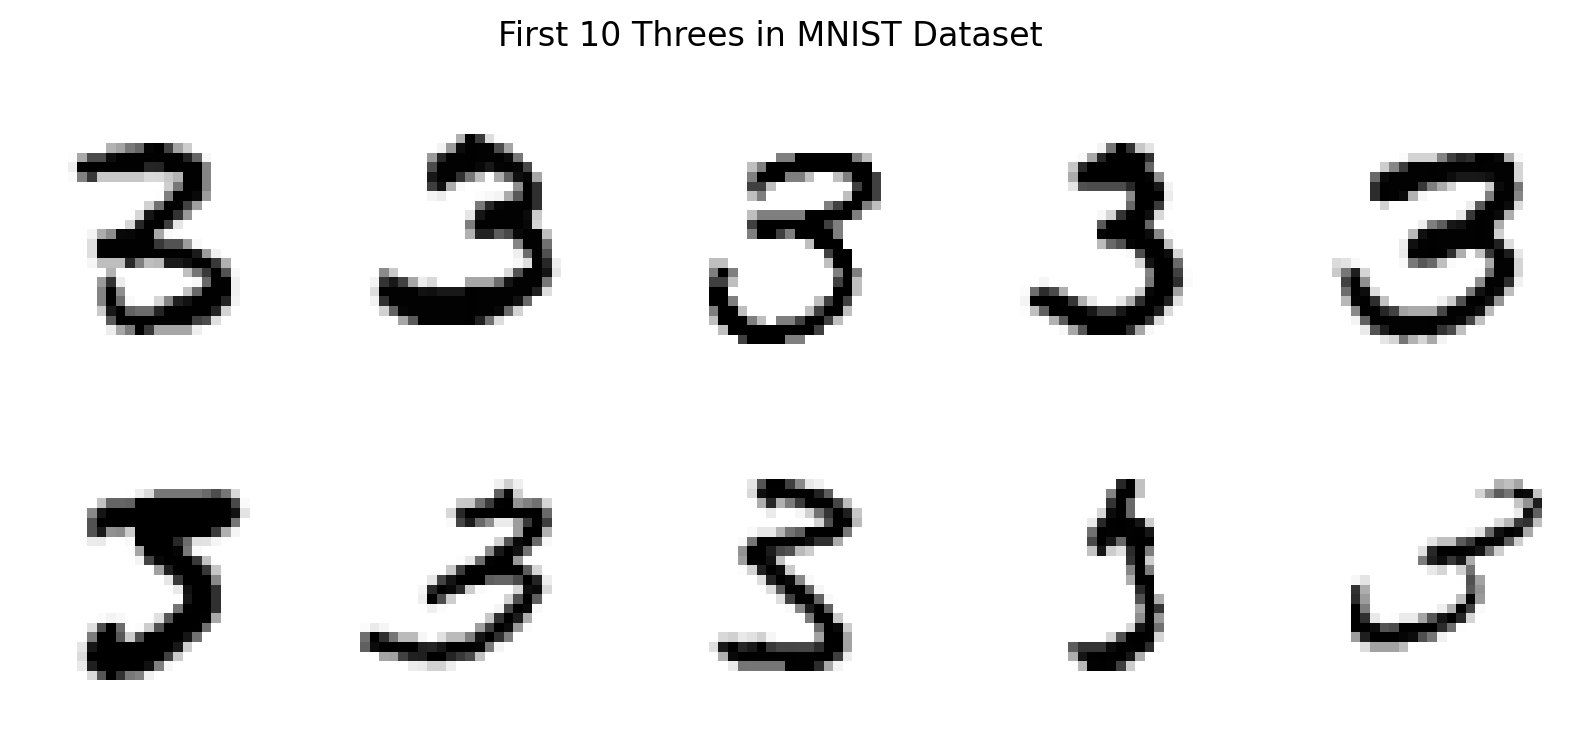

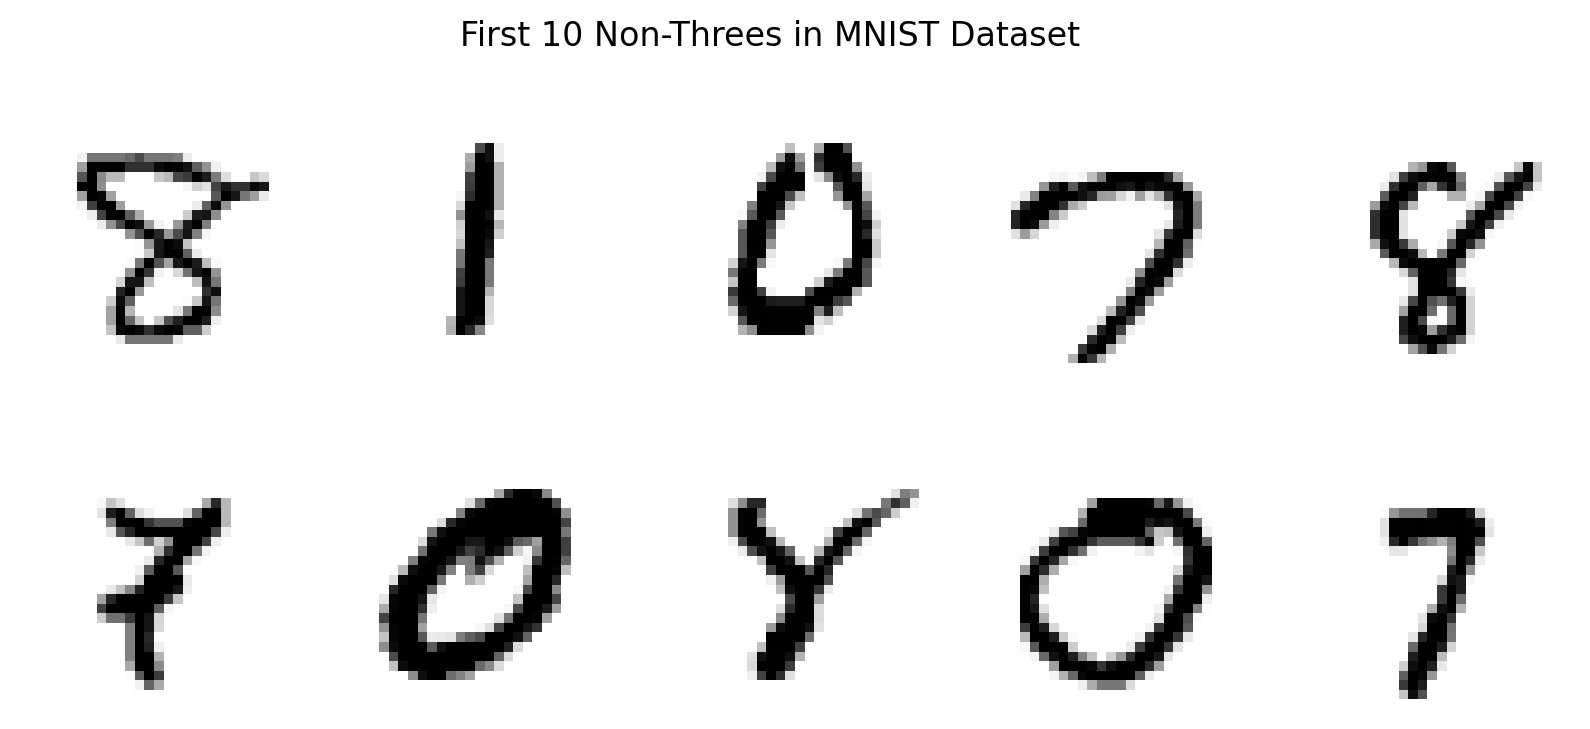

In [2]:
# reshape the data from 784 to 28x28
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

# plot the first 10 images of 3's
fig = plt.figure(figsize=(10, 4), dpi=200)
i = 0
for x in range(len(y_train)):
  if i == 10:
    break
  if y_train[x] == 1:
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[x], cmap='gray_r')
    plt.axis('off')
    i += 1
fig.suptitle("First 10 Threes in MNIST Dataset")
plt.show()

# plot the first 10 images of non-3's
fig = plt.figure(figsize=(10, 4), dpi=200)
i = 0
for x in range(len(y_train)):
  if i == 10:
    break
  if y_train[x] != 1:
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[x], cmap='gray_r')
    plt.axis('off')
    i += 1
fig.suptitle("First 10 Non-Threes in MNIST Dataset")
plt.show()

**b. Plotting the number of samples by class:**

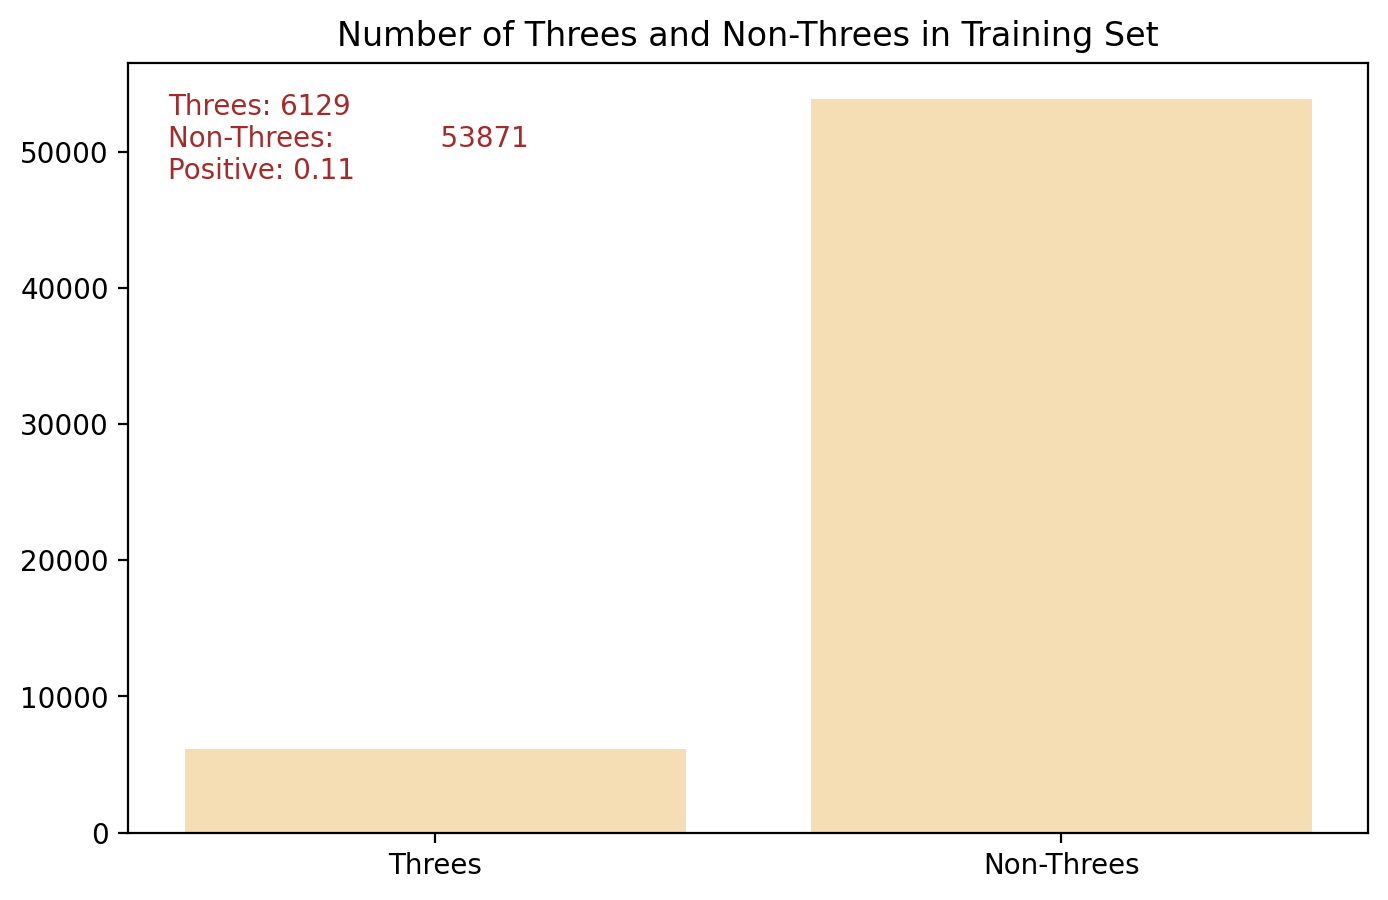

In [3]:
# number of threes in the training set
threes = np.where(y_train == 1, 1, 0)
# number of non-threes in the training set
not_threes = np.where(y_train == 0, 1, 0)

# bar plot of the number of threes and non-threes in the training set
plt.figure(figsize=(8, 5), dpi=200)
plt.bar(['Threes', 'Non-Threes'], [threes.sum(), not_threes.sum()], color='wheat')
plt.title("Number of Threes and Non-Threes in Training Set")
plt.figtext(0.15, 0.85, f"Threes: {threes.sum()}\nNon-Threes:\
            {not_threes.sum()}\nPositive: {np.round(threes.sum()/not_threes.sum(), 2)}", \
            ha="left", va="top", color="brown")
plt.show()

**c. Identifying the optimal regularization parameter**

In [4]:
# generate a list of 20 Cs to test
Cs = np.logspace(-4, 4, 20)
# init list to store the number of non-zero parameters
non_zero_weights = []
# init list to store the cross-entropy loss for each C value
log_losses = []
# init list for areas under ROC curves for each C
aucs = []
# init list for F1 scores for each C
f1s = []

for c in Cs:
  # instantiate the logistic regression model, w the Cs, 
  # penalty l1, and solver liblinear
  lr = LogisticRegression(C=c, penalty='l1', solver='liblinear')
  # fit the model, return original shape of X_train
  lr.fit(X_train.reshape(-1, 784), y_train)
  # get the non-zero parameters
  non_zero_weights.append(np.count_nonzero(lr.coef_))
  # get the probabilities of the positive class on the 
  # test set (reshape X_test to original shape)
  proba = lr.predict_proba(X_test.reshape(-1, 784))
  # get the log loss using the proba from above
  log_losses.append(log_loss(y_test, proba))
  # get the ROC AUC score using the proba from above
  aucs.append(roc_auc_score(y_test, proba[:, 1]))
  # get the predicted classes using proba & threshold 0.5
  y_pred = np.where(proba[:, 1] > 0.5, 1, 0)
  # get the F1 score, thank you sklearn
  f1s.append(f1_score(y_test, y_pred))

**Plotting:**

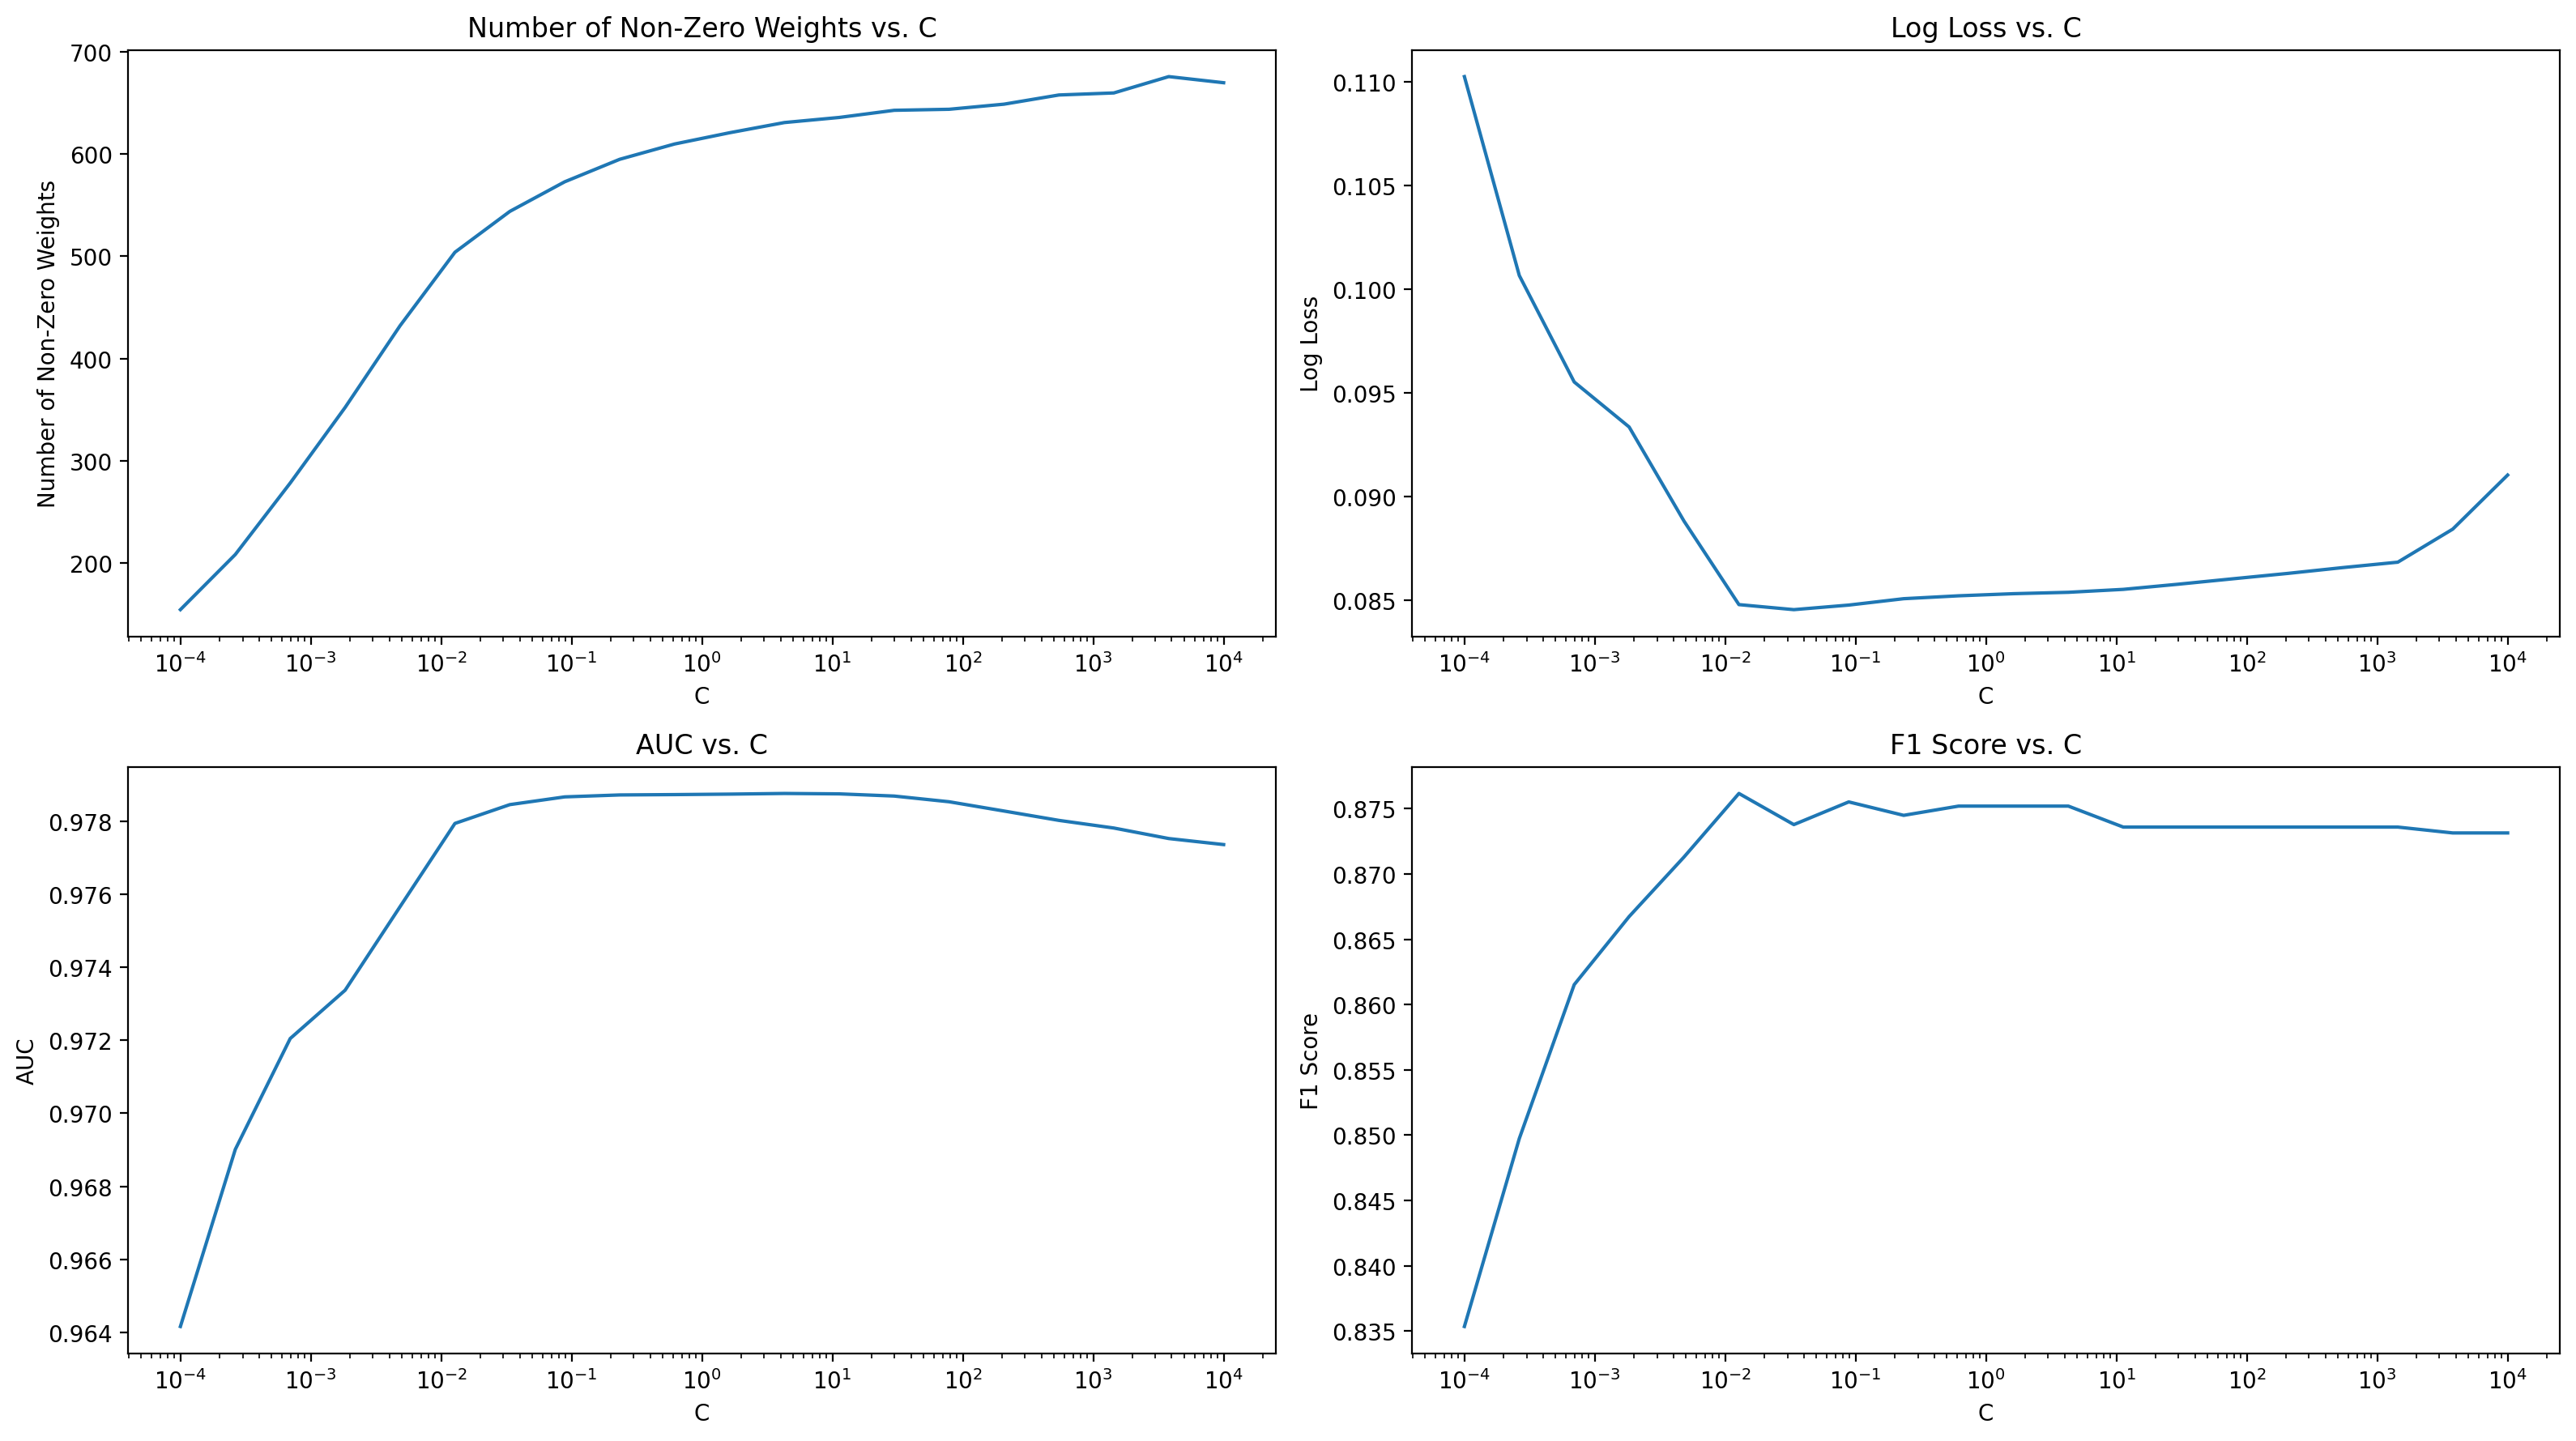

In [5]:
fig = plt.figure(figsize=(16, 9), dpi=200)
plt.subplot(2, 2, 1)
plt.plot(Cs, non_zero_weights)
plt.xscale('log')
plt.title("Number of Non-Zero Weights vs. C")
plt.xlabel("C")
plt.ylabel("Number of Non-Zero Weights")

plt.subplot(2, 2, 2)
plt.plot(Cs, log_losses)
plt.xscale('log')
plt.title("Log Loss vs. C")
plt.xlabel("C")
plt.ylabel("Log Loss")

plt.subplot(2, 2, 3)
plt.plot(Cs, aucs)
plt.xscale('log')
plt.title("AUC vs. C")
plt.xlabel("C")
plt.ylabel("AUC")

plt.subplot(2, 2, 4)
plt.plot(Cs, f1s)
plt.xscale('log')
plt.title("F1 Score vs. C")
plt.xlabel("C")
plt.ylabel("F1 Score")

plt.tight_layout()
plt.show()

**Picking the nicest C**

Looking at the plots, $10^{-2}$ seems to be the sweet spot. To me, the most obvious place to make this decision was the F1 plot, where $10^{-2}$ has the best score. Precision and recall are most in balance here. The ROC-AUC plot also has a decently high value at $10^{-2}$, implying that the model will be decent at discriminating between classes. Log loss is also at a minimum between $10^{-2}$ and $10^{-1}$, with the model having the highest accuracy here. When it comes to the non-zero parameters plot, the rate of increase in the number of non-zero parameters appears to decline at $10^{-2}$.

**d. Comparing model performance using logistic regression with a minimal C-value and an optimal C-value, a Linear Discriminant Analysis classifier, and a Random Forest classifier:**

In [6]:
# imports for LDA classifier, random forest classifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

precisions = []
recalls = []
aucs = []
false_positive_rates = []
true_positive_rates = []
aucs_roc = []

lr = LogisticRegression(C=1e100, penalty='l1', solver='liblinear')
lr.fit(X_train.reshape(-1, 784), y_train)
precision, recall, threshold = precision_recall_curve(y_test, 
                    lr.predict_proba(X_test.reshape(-1, 784))[:, 1])
aucs.append(auc(recall, precision))
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, 
                    lr.predict_proba(X_test.reshape(-1, 784))[:, 1])
precisions.append(precision)
recalls.append(recall)
aucs_roc.append(auc(false_positive_rate, true_positive_rate))
false_positive_rates.append(false_positive_rate)
true_positive_rates.append(true_positive_rate)

lr = LogisticRegression(C=0.01, penalty='l1', solver='liblinear')
lr.fit(X_train.reshape(-1, 784), y_train)
precision, recall, threshold = precision_recall_curve(y_test, 
                    lr.predict_proba(X_test.reshape(-1, 784))[:, 1])
aucs.append(auc(recall, precision))
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, 
                    lr.predict_proba(X_test.reshape(-1, 784))[:, 1])
precisions.append(precision)
recalls.append(recall)
aucs_roc.append(auc(false_positive_rate, true_positive_rate))
false_positive_rates.append(false_positive_rate)
true_positive_rates.append(true_positive_rate)

# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train.reshape(-1, 784), y_train)
precision, recall, threshold = precision_recall_curve(y_test, 
                    lda.predict_proba(X_test.reshape(-1, 784))[:, 1])
aucs.append(auc(recall, precision))
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, 
                    lda.predict_proba(X_test.reshape(-1, 784))[:, 1])
precisions.append(precision)
recalls.append(recall)
aucs_roc.append(auc(false_positive_rate, true_positive_rate))
false_positive_rates.append(false_positive_rate)
true_positive_rates.append(true_positive_rate)

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train.reshape(-1, 784), y_train)
precision, recall, threshold = precision_recall_curve(y_test, 
                    rf.predict_proba(X_test.reshape(-1, 784))[:, 1])
aucs.append(auc(recall, precision))
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, 
                    rf.predict_proba(X_test.reshape(-1, 784))[:, 1])
precisions.append(precision)
recalls.append(recall)
aucs_roc.append(auc(false_positive_rate, true_positive_rate))
false_positive_rates.append(false_positive_rate)
true_positive_rates.append(true_positive_rate)

**Plotting ROC and PR curves:**

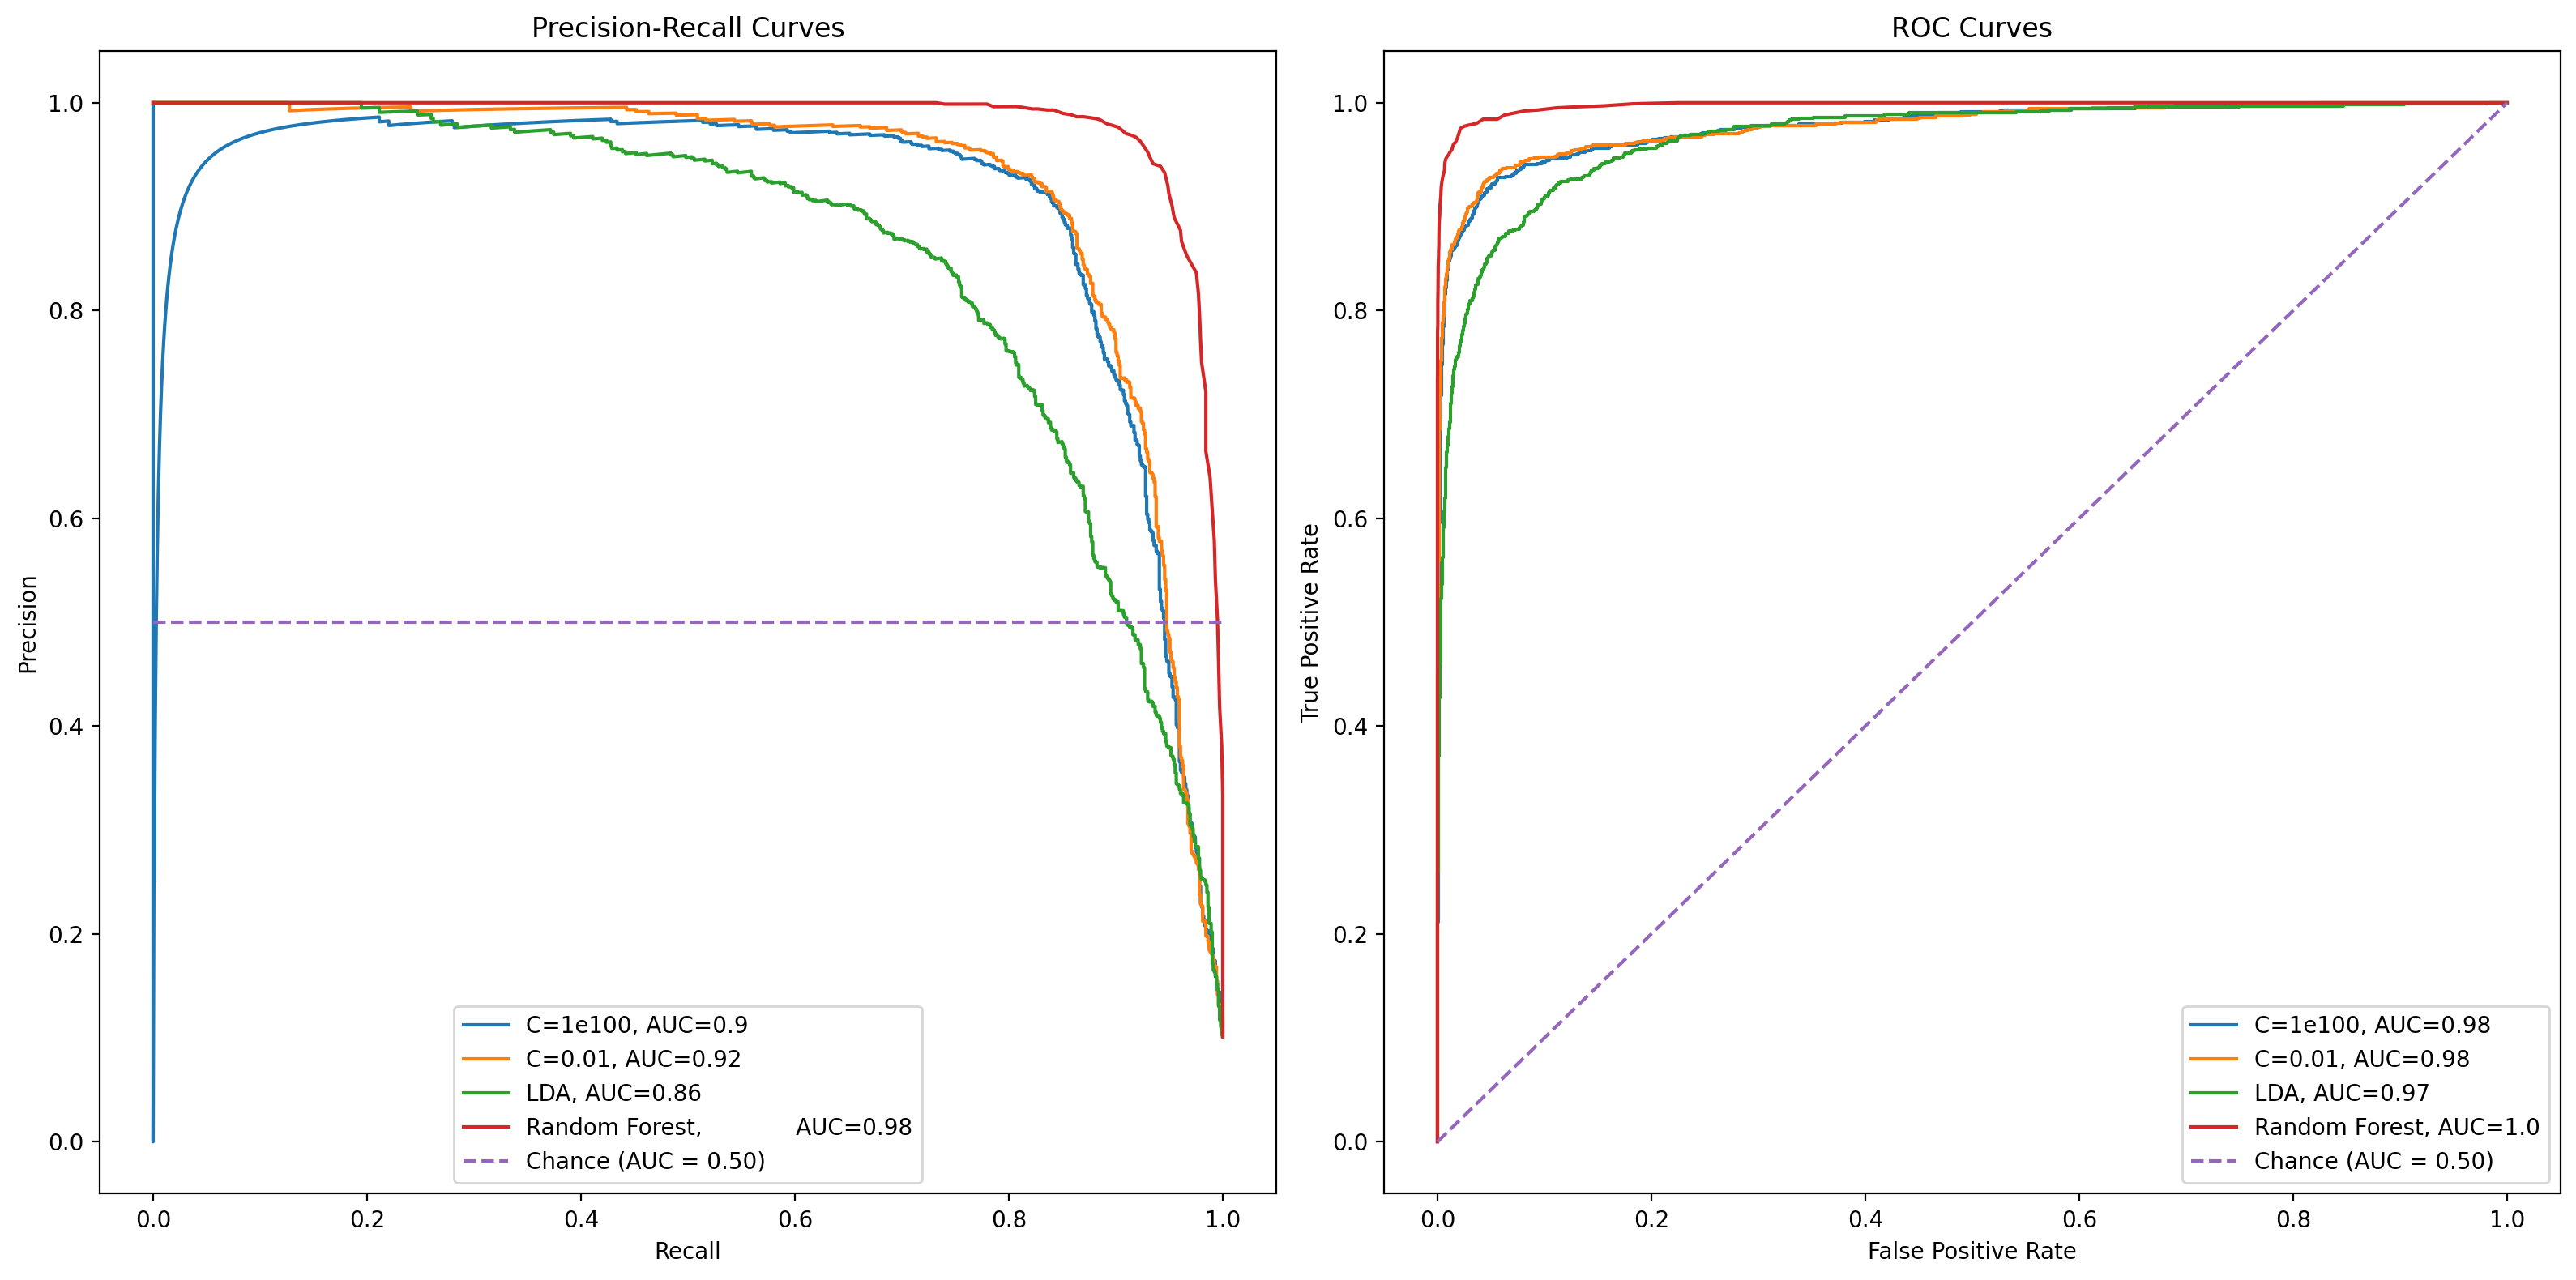

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=200)

# Plotting Precision-Recall curves
axs[0].plot(recalls[0], precisions[0], label=f"C=1e100, AUC={np.round(aucs[0], 2)}")
axs[0].plot(recalls[1], precisions[1], label=f"C=0.01, AUC={np.round(aucs[1], 2)}")
axs[0].plot(recalls[2], precisions[2], label=f"LDA, AUC={np.round(aucs[2], 2)}")
axs[0].plot(recalls[3], precisions[3], label=f"Random Forest, \
            AUC={np.round(aucs[3], 2)}")
# plot the chance line
axs[0].plot([0, 1], [0.5, 0.5], linestyle='--', label='Chance (AUC = 0.50)')
axs[0].set_title("Precision-Recall Curves")
axs[0].set_xlabel("Recall")
axs[0].set_ylabel("Precision")
axs[0].legend()

# Plotting ROC curves
axs[1].plot(false_positive_rates[0], true_positive_rates[0], 
            label=f"C=1e100, AUC={np.round(aucs_roc[0], 2)}")
axs[1].plot(false_positive_rates[1], true_positive_rates[1], 
            label=f"C=0.01, AUC={np.round(aucs_roc[1], 2)}")
axs[1].plot(false_positive_rates[2], true_positive_rates[2], 
            label=f"LDA, AUC={np.round(aucs_roc[2], 2)}")
axs[1].plot(false_positive_rates[3], true_positive_rates[3], 
            label=f"Random Forest, AUC={np.round(aucs_roc[3], 2)}")
# plot the chance line
axs[1].plot([0, 1], [0, 1], linestyle='--', label='Chance (AUC = 0.50)')
axs[1].set_title("ROC Curves")
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].legend()

plt.tight_layout()
plt.show()

I am quite surprised that after all of that, the choice of the optimal regularization parameter for logistic regression only resulted in a $2\%$ increase in the area under the PR curve, when pitted against the same model with a ridiculously high C-value. 

Random forests are clearly the way to go for this problem, with a perfect AUC-ROC score, and by far the best PR-AUC score.